# Описание проекта

**Описание проекта:** Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей которые готовы совершить покупку в ближайшее время.
Предоставлены данные по истории покупателей. Есть история реакции клиента на преведенные коммуникации. Коммуникация это - промо-предложение, направленное в смс / push сообщении, или электронной почте. По каждому товару проставлена категория, которая помогает определить насколько покупатель “латентен” (предпочтителен) к этой группе товаров.<br>

**Цель** -  создать модель прогнозирования покупки каждым покупателем в ближайшие 90 дней. Это нужно для улучшения работы и повышения эффективности марктетинговых компаний.<br>

**Описание данных:**<br>
* `apparel-purchases` - Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук. В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например автотовары-аксессуары-освежители), но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам. Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например (4, 28, 44, 1594) или (4, 44, 1594). Необходимо обработать такие случаи.
    * client_id - идентификатор клиента
    * quantity - количество единиц товара
    * price - цена товара
    * category_ids - идентификаторы категорий
    * date - дата покупки
    * message_id - идентификатор сообщения из рассылки<br><br>
    
* `apparel-messages` - Рассылки, которые были отправлены клиентам из таблицы покупок.<br>
    * `bulk_campaign_id` - идентификатор рассылки
    * `client_id` - идентификатор клиента
    * `message_id` - идентификатор сообщения
    * `event` - действие с сообщением (отправлено, открыто, покупка…)
    * `channel` - канал рассылки
    * `date` - дата действия
    * `created_at` - дата-время полностью<br><br>
    
* target - Целевой признак
    * `client_id` - идентификатор клиента
    * `target` - клиент совершил покупку в целевом периоде<br><br>
    
* full_campaign_daily_event - Агрегация общей базы рассылок по дням и типам событий
    * `date` - дата
    * `bulk_campaign_id` - идентификатор рассылки
    * `count_event` - общее количество каждого события event
    * `nunique_event` - количество уникальных client_id в каждом событии. В именах колонок найдете все типы событий `event`.<br><br>
* full_campaign_daily_event_channel - Агрегация по дням с учетом событий и каналов рассылки
    * `date` - дата
    * `bulk_campaign_id` - идентификатор рассылки
    * `count_event*_channel` - общее количество каждого события по каналам
    * `nunique_event*_channel` - количество уникальных client_id по событиям и каналам. D именах колонок есть все типы событий event и каналов рассылки `channel`.

# Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import warnings
import re
import seaborn as sns
import shap

import matplotlib.pyplot as plt

from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE
)
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score, 
    roc_auc_score,
    roc_curve,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None) # Отображать все поля DF
pd.set_option('display.max_colwidth', None)  # Отображать все содержание полей DF

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

blue_start = color.BLUE
red_start = color.RED
purple_start = color.PURPLE
color_end   = color.END

# Функции

## `column_analiser` - визуализация числовых признаков

In [3]:
def column_analiser(
    df_,
    column_,
    x_label='',
    y_label='',
    print_unique = False,
    bins_= 70,
    figsize_ = (15, 10),
    height_ratios_ = [1, 3],
    hue_lst_ = [],
    kde_plot_log_flag_ = False,
    kde_plot_figsize_ = (15, 10),
    kde_plot_title = '',
    kde_plot_x_label = '',
    kde_plot_y_label = ''
):

    record_count = df_.shape[0]
    
    print('---------------------------------------------------------------------------------------------------------')
    print(bold_start, f'Поле : {column_} - {x_label}', bold_end)
    isna_count = df_[column_].isna().sum()
    print(bold_start, '    Количество пропусков - ', bold_end , isna_count)
    print(bold_start, '    Доля пропусков - ', bold_end , round((isna_count / record_count) * 100, 2), '%')
    print('')
    
    print(df_[column_].describe())
    if print_unique:
        print('Список значений')
        print(df_[column_].unique())
        
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = figsize_, gridspec_kw={'height_ratios': height_ratios_})
        
    if kde_plot_log_flag_:
        axes[0] = np.log1p(df_[column_]).plot(
            kind = 'box',
            ax = axes[0],
            vert=False)
        axes[1] = plt.hist(
            np.log1p(df_[column_]),
            bins=bins_
        )
    else:
        axes[0] = df_[column_].plot(
            kind = 'box',
            ax = axes[0],
            vert=False)
        axes[1] = plt.hist(
            df_[column_],
            bins=bins_,
        )

    axes[0].set_ylabel(y_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('Распределение')    
    plt.show()    
    
    if len(hue_lst_) > 0:
        for hue_ in hue_lst_:
            if kde_plot_log_flag_:
                fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = kde_plot_figsize_)
                sns.kdeplot(data = df_,
                            x = np.log1p(df_[column_]),
                            hue = hue_,
                            fill = True)
            else:
                fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = kde_plot_figsize_)
                sns.kdeplot(data = df_,
                            x = df_[column_],
                            hue = hue_,
                            fill = True)
                
            plt.title(kde_plot_title)
            plt.xlabel(kde_plot_x_label)
            plt.ylabel(kde_plot_y_label)
            plt.show()

## `df_inf` - информация о дата фрейме

In [4]:
def df_inf(df, head_row=5, drop_duplicates_flag=False):
    print(purple_start, '-------------------------------------------------------------------------------------------------------------------------------------', color_end)
    try:
        df_name = df.name
        print(blue_start,'Имя:', df_name, color_end)
    except:
        df_name = 'Не определено'
        display(blue_start,'Имя: Не определено', color_end)
    print('')
    
    df_shape_ = df.shape
    
    print(blue_start, df_name, '(первые', head_row, 'строк)', color_end)
    display(df.head(head_row))
    print('')
    
    print(blue_start,'Информация: ', color_end)
    df.info()
    print('')

    try:
        print(blue_start,'Описание числовых полей: ', color_end)
        display(df.describe(exclude=['O']))
    except ValueError:
        print(blue_start,'Числовых полей нет!', color_end)
        
    print('')
    
    try:
        print(blue_start,'Описание не числовых полей: ', color_end)
        display(df.describe(include=['O']))
    except ValueError:
        print(blue_start,'Не числовых полей нет!', color_end)
        
    print('')

    print(blue_start,'Пропуски: ', color_end)
    display(df.isna().sum().T)
    print('')
    
    df_duplicates = []
    df_duplicates = df[df.duplicated()]

    #isna_record_count  = df[df.isnull().any(axis=1)].drop_duplicates().shape[0]
    record_count = df_shape_[0]
    isna_record_count  = df[df.isnull().any(axis=1)].shape[0]
    
    print(blue_start, 'Доля записей, содержащих пропуски:',color_end, round((isna_record_count/record_count)*100, 2),'%')
    
    if len(df_duplicates) > 0:
        print(' ')
        print(blue_start,'Количество дубликатов:',len(df_duplicates), color_end)
        print(blue_start,'Дубликаты (первые', head_row, 'строк)', color_end)
        display(df_duplicates.head(head_row))
        if drop_duplicates_flag:
            print(blue_start,'Дубликаты удалены!', color_end)
            df.drop_duplicates(keep = 'first', inplace = True)
            df_duplicates = df[df.duplicated()]
            print(blue_start,'Количество дубликатов после удаления:',len(df_duplicates), color_end)
    else:
        print(blue_start,'Дубликаты не обнаружены!', color_end)
    print(' ')
    return df_duplicates, df_shape_

## `load_date` - загрузка файлов

In [5]:
def load_date(
    file_name_,
    parse_dates_,
    head_rows_ = 1):
    
    read_csv_res = red_start + 'ОШИБКА - '+file_name_+'- не загружен' + color_end
    err = False
    try:
        df_ = pd.read_csv(
            file_name_,
            parse_dates = parse_dates_
        )
        read_csv_res = blue_start + file_name_ + ' - локальный' + color_end
    except:
        try:
            df_ = pd.read_csv(
                '/datasets/' + file_name_,
                parse_dates = parse_dates_
            )
            read_csv_res = blue_start + file_name_ + ' - тренажер' + color_end
        except:
            try:
                df_ = pd.read_csv(
                    '/datasets/' + file_name_,
                    parse_dates = parse_dates_
                )
                read_csv_res = file_name_ + ' - http://'
            except:
                read_csv_res = red_start + 'ОШИБКА - '+file_name_+'- не загружен' + color_end
                err = True
    print(read_csv_res)
    if err:
        return 'ОШИБКА ЧТЕНИЯ'
    else:
        df_.name = file_name_
        display(df_.head(head_rows_))
        return df_

## `check_categorical_fields` - вывод уникальных значений полей

In [6]:
def check_categorical_fields(df_, fields_lst, print_unique_val=False):
    record_count = df_.shape[0]
    for field in fields_lst:
        print('---------------------------------------------------------------------------------------------------------')
        print(blue_start, 'Поле - ', color_end, field)
        print(blue_start, 'Количество уникальных значений -  ', color_end, len(df_[field].unique()))

        isna_count = df_[field].isna().sum()
        print(blue_start, 'Количество пропусков - ', color_end, isna_count)
        if isna_count > 0:
            print(blue_start, 'Доля пропусков - ', color_end, round((isna_count / record_count) * 100, 2), bold_start, '%')
        print('')
        if print_unique_val:
            with pd.option_context("display.max_rows", None):
                display(pd.Series(df_[field].unique()).sort_values())

## `column_analiser` - визуализация числовых признаков

In [7]:
def column_analiser(
    df_,
    column_,
    x_label='',
    y_label='',
    print_unique = False,
    bins_= 70,
    figsize_ = (15, 10),
    height_ratios_ = [1, 3],
    hue_lst_ = [],
    kde_plot_log_flag_ = False,
    kde_plot_figsize_ = (15, 10),
    kde_plot_title = '',
    kde_plot_x_label = '',
    kde_plot_y_label = ''
):

    record_count = df_.shape[0]
    
    print('---------------------------------------------------------------------------------------------------------')
    print(blue_start, f'Поле : {column_} - {x_label}', color_end)
    isna_count = df_[column_].isna().sum()
    print(blue_start, '    Количество пропусков - ', color_end, isna_count)
    print(blue_start, '    Доля пропусков - ', color_end, round((isna_count / record_count) * 100, 2), '%')
    print('')


    
    print(df_[column_].describe())
    if print_unique:
        print('Список значений')
        print(df_[column_].unique())
        
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = figsize_, gridspec_kw={'height_ratios': height_ratios_})
        
    if kde_plot_log_flag_:
        axes[0] = np.log1p(df_[column_]).plot(
            kind = 'box',
            ax = axes[0],
            vert=False)
        axes[1] = plt.hist(
            np.log1p(df_[column_]),
            bins=bins_
        )
    else:
        axes[0] = df_[column_].plot(
            kind = 'box',
            ax = axes[0],
            vert=False)
        axes[1] = plt.hist(
            df_[column_],
            bins=bins_,
        )

    axes[0].set_ylabel(y_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('Распределение')    
    plt.show()    
    
    if len(hue_lst_) > 0:
        for hue_ in hue_lst_:
            if kde_plot_log_flag_:
                fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = kde_plot_figsize_)
                sns.kdeplot(data = df_,
                            x = np.log1p(df_[column_]),
                            hue = hue_,
                            fill = True)
            else:
                fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = kde_plot_figsize_)
                sns.kdeplot(data = df_,
                            x = df_[column_],
                            hue = hue_,
                            fill = True)
                
            plt.title(kde_plot_title)
            plt.xlabel(kde_plot_x_label)
            plt.ylabel(kde_plot_y_label)
            plt.show()

# Загрузка данных

In [8]:
apparel_messages_df = load_date(file_name_ = 'apparel-messages.csv', parse_dates_ = ['date', 'created_at'], head_rows_ = 1)
apparel_purchases_df = load_date(file_name_ = 'apparel-purchases.csv', parse_dates_ = ['date'], head_rows_ = 1)
apparel_target_binary_df = load_date(file_name_ = 'apparel-target_binary.csv', parse_dates_ = [], head_rows_ = 1)

# full_campaign_daily_event_df = load_date(file_name_ = 'full_campaign_daily_event.csv', parse_dates_ = ['date'], head_rows_ = 1)
# full_campaign_daily_event_channel_df = load_date(file_name_ = 'full_campaign_daily_event_channel.csv', parse_dates_ = ['date'], head_rows_ = 1)

apparel-messages.csv - локальный


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20


apparel-purchases.csv - локальный


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d


apparel-target_binary.csv - локальный


,client_id,target
0,1515915625468060902,0


## Информация о сформированных фреймах данных, удаление явных дубликатов.

In [9]:
# пример сообщения с дублем клика в сообщении
apparel_messages_df.query('message_id == "1515915625554535987-5723-62e2af08e00da"')

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964169,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,send,mobile_push,2022-07-28,2022-07-28 15:58:49
964231,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
968252,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,purchase,mobile_push,2022-07-28,2022-07-28 17:29:17
968266,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,purchase,mobile_push,2022-07-28,2022-07-28 17:38:31


In [10]:
#duplicates_df, apparel_messages_df__original_shape = df_inf(df = apparel_messages_df, head_row = 3, drop_duplicates_flag = True)
duplicates_df, apparel_purchases_df__original_shape = df_inf(df = apparel_purchases_df, head_row = 3, drop_duplicates_flag = False)
#duplicates_df, apparel_target_binary_df__original_shape = df_inf(df = apparel_target_binary_df, head_row = 3, drop_duplicates_flag = False)

 ------------------------------------------------------------------------------------------------------------------------------------- 
 Имя: apparel-purchases.csv 

 apparel-purchases.csv (первые 3 строк) 


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843



 Информация:  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB

 Описание числовых полей:  


,client_id,quantity,price,date
count,2.022080e+05,202208.000000,202208.000000,202208
mean,1.515916e+18,1.006483,1193.301516,2023-03-17 02:49:35.739832064
min,1.515916e+18,1.000000,1.000000,2022-05-16 00:00:00
25%,1.515916e+18,1.000000,352.000000,2022-11-12 00:00:00
50%,1.515916e+18,1.000000,987.000000,2023-04-12 00:00:00
75%,1.515916e+18,1.000000,1699.000000,2023-07-03 00:00:00
max,1.515916e+18,30.000000,85499.000000,2024-02-16 00:00:00
std,1.459458e+08,0.184384,1342.252664,NaN



 Описание не числовых полей:  


,category_ids,message_id
count,202208,202208
unique,933,50204
top,"['4', '28', '57', '431']",1515915625489095763-6251-6311b13a4cf78
freq,8626,365



 Пропуски:  


client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64


 Доля записей, содержащих пропуски:  0.0 %
 
 Количество дубликатов: 73020 
 Дубликаты (первые 3 строк) 


,client_id,quantity,price,category_ids,date,message_id
12,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
22,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
42,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa


In [11]:
min_purchases_date = apparel_purchases_df['date'].min()
max_purchases_date = apparel_purchases_df['date'].max()
print(blue_start, 'Минимальная  дата покупки - ', color_end, min_purchases_date)
print(blue_start, 'Максимальная дата покупки - ', color_end, max_purchases_date)

 Минимальная  дата покупки -   2022-05-16 00:00:00
 Максимальная дата покупки -   2024-02-16 00:00:00


In [12]:
apparel_purchases_df['category_series'] = apparel_purchases_df['category_ids'].apply(
    lambda x: 
        list(
            filter(None, re.sub("None|\[|\]|'|\s", '', x).split(','))
            )
)
apparel_purchases_df['category_count'] = apparel_purchases_df['category_series'].apply(lambda x: len(x))

In [13]:
print(blue_start, 'Максимальное количество категорий - ', color_end, apparel_purchases_df['category_count'].max())
print(blue_start, 'Минимальное количество категорий - ', color_end, apparel_purchases_df['category_count'].min())

 Максимальное количество категорий -   5
 Минимальное количество категорий -   0


In [14]:
print('apparel_target_binary_df')
check_categorical_fields(apparel_target_binary_df, ['client_id'], print_unique_val = False)
print('apparel_purchases_df')
check_categorical_fields(apparel_purchases_df, ['client_id'], print_unique_val = False)
print('apparel_messages_df')
check_categorical_fields(apparel_messages_df, ['client_id'], print_unique_val = False)

print('apparel_purchases_df')
check_categorical_fields(apparel_purchases_df, ['message_id'], print_unique_val = False)
print('apparel_messages_df')
check_categorical_fields(apparel_messages_df, ['message_id'], print_unique_val = False)

apparel_target_binary_df
---------------------------------------------------------------------------------------------------------
 Поле -   client_id
 Количество уникальных значений -    49849
 Количество пропусков -   0

apparel_purchases_df
---------------------------------------------------------------------------------------------------------
 Поле -   client_id
 Количество уникальных значений -    49849
 Количество пропусков -   0

apparel_messages_df
---------------------------------------------------------------------------------------------------------
 Поле -   client_id
 Количество уникальных значений -    53329
 Количество пропусков -   0

apparel_purchases_df
---------------------------------------------------------------------------------------------------------
 Поле -   message_id
 Количество уникальных значений -    50204
 Количество пропусков -   0

apparel_messages_df
----------------------------------------------------------------------------------------------------

In [15]:
purchases_mesage_clients_not_in_target = apparel_purchases_df.loc[~apparel_purchases_df['client_id'].isin(apparel_target_binary_df['client_id']), ['client_id']].drop_duplicates()
print(blue_start, 'Клиенты из apparel_purchases_df, которых нет в apparel_target_binary_df - ', color_end, len(purchases_mesage_clients_not_in_target))

target_clients_not_in_purchases_mesage = apparel_target_binary_df.loc[~apparel_target_binary_df['client_id'].isin(apparel_purchases_df['client_id']), ['client_id']].drop_duplicates()
print(blue_start, 'Клиенты из apparel_target_binary_df, которых нет в apparel_purchases_df - ', color_end, len(target_clients_not_in_purchases_mesage))

print('')

purchases_mesage_clients_not_in_messages = apparel_purchases_df.loc[~apparel_purchases_df['client_id'].isin(apparel_messages_df['client_id']), ['client_id']].drop_duplicates()
print(blue_start, 'Клиенты из apparel_purchases_df, которых нет в apparel_messages_df - ', color_end, len(purchases_mesage_clients_not_in_messages))

messages_clients_not_in_purchases = apparel_messages_df.loc[~apparel_messages_df['client_id'].isin(apparel_purchases_df['client_id']), ['client_id']].drop_duplicates()
print(blue_start, 'Клиенты из apparel_messages_df, которых нет в apparel_purchases_df - ', color_end, len(messages_clients_not_in_purchases))

print('')

purchases_mesage_not_in_messages = apparel_purchases_df.loc[~apparel_purchases_df['message_id'].isin(apparel_messages_df['message_id']), ['message_id']].drop_duplicates()
print(blue_start, 'Сообщения из apparel_purchases_df, которых нет в apparel_messages_df - ', color_end, len(purchases_mesage_not_in_messages))

messages_not_in_purchases_mesage = apparel_messages_df.loc[~apparel_messages_df['message_id'].isin(apparel_purchases_df['message_id']), ['message_id']].drop_duplicates()
print(blue_start, 'Сообщения из apparel_messages_df, которых нет в apparel_purchases_df - ', color_end, len(messages_not_in_purchases_mesage))

 Клиенты из apparel_purchases_df, которых нет в apparel_target_binary_df -   0
 Клиенты из apparel_target_binary_df, которых нет в apparel_purchases_df -   0

 Клиенты из apparel_purchases_df, которых нет в apparel_messages_df -   7867
 Клиенты из apparel_messages_df, которых нет в apparel_purchases_df -   11347

 Сообщения из apparel_purchases_df, которых нет в apparel_messages_df -   394
 Сообщения из apparel_messages_df, которых нет в apparel_purchases_df -   9011857


## **`Выводы`**

* Для формирования модели загружена информация из файлов:
    * `apparel-messages.csv`
    * `apparel-purchases.csv`
    * `apparel-target_binary.csv`
* Загруженные данные соответствуют описанию.
* Временной период покупок с **2022-05-16** по **2024-02-16**.
* Данные о целевом признаке и о покупках соответствуют по `client_id`.
* Обнаруужена информация о покупках клиентов, которая не отражена в данных о сообщениях.
* Обнаруужена информация о сообщениях, которая не отражена в данных о покупках.
* Удалены явные дубликаты (48610  записей) для **apparel_messages_df**, т.к. одинаковые события по одному сообщению, произошедшие в одну секуду создают переизбыток информации (пример - **mesage_id == 1515915625554535987-5723-62e2af08e00da**, содержит две покупки за 1 секуду)
* Обнаружено 73020 дублей в **apparel_purchases_df**. Дубли не удалены, т.к. клиент может делать одинаковые покупки в течении дня. Вопрос для обсуждения с заказчиком.

&ensp;&ensp;&ensp;&ensp; **Идентификатор целевого признака - поле `client_id`. DataFrame для формирование модели будет построен по схеме:**
<br>
* `client_id` - **уникальный ключ**
* `(future_1` ... `furure_n)` - **входящие признаки**
* `target` - **целевой признак**
  
&ensp;&ensp;&ensp;&ensp; **Состав значений `client_id` будет соответствовать уникальным значениям `apparel-purchases`, т.к. они соответствуют значениям `client_id` из DataFrame целевого признака  `apparel-target_binary`**.

# Формирование DataFrame для формирования модели `client_info_df`

## `date_min`, `date_max`, `purchase_count`, `purchase_sum`

In [16]:
%%time

print(blue_start, 'Количество записей apparel_target_binary_df = ', color_end, len(apparel_target_binary_df))

# Формирование агрегированных данных по client_id из apparel_purchases_df (по покупкам)
# date_min - минимальная дата покупки
# date_max - максимальная дата покупки
# purchase_count - количество покупок
# purchase_sum - сумма покупок

apparel_purchases_df['purchase_sum'] = apparel_purchases_df['quantity'] * apparel_purchases_df['price']
client_info_df = apparel_purchases_df.groupby(['client_id']).agg({'date' : ['min', 'max', 'count'], 'purchase_sum' : ['sum']})
client_info_df.reset_index(inplace = True)
client_info_df.columns = ['client_id', 'date_min', 'date_max', 'purchase_count', 'purchase_sum']

print(blue_start, 'Количество записей client_info_df = ', color_end, len(client_info_df))

 Количество записей apparel_target_binary_df =   49849
 Количество записей client_info_df =   49849
CPU times: total: 31.2 ms
Wall time: 37.9 ms


## `date_delta` - Период покупок (Разница между первой и последней покупкой в днях)

In [17]:
# Формирование признака date_delta - Период покупок (Разница между первой и последней покупкой в днях)
client_info_df['date_delta'] = (client_info_df['date_max'] - client_info_df['date_min']).dt.days
client_info_df['date_delta'] = client_info_df['date_delta'].astype(int)

## `days_without_purchases` -  Количество дней, прошедших с даты последней покупки.

In [18]:
# Формирование признака days_without_purchases - Количество дней с даты последней покупки (Разница между первой и последней покупкой в днях)
client_info_df['days_without_purchases'] = (max_purchases_date - client_info_df['date_max']).dt.days
client_info_df['days_without_purchases'] = client_info_df['days_without_purchases'].astype(int)

## `purchase_day_count` - Количество дней, когда клиент совершал покупки.

In [19]:
# Формирование признака purchase_day_count - Количество дней, когда клиент совершал покупки.
client_tmp_df = apparel_purchases_df[['client_id', 'date']].drop_duplicates().groupby('client_id').agg('count')
client_tmp_df.reset_index(inplace = True)
client_tmp_df.columns = ['client_id', 'purchase_day_count']

client_info_df = pd.merge(client_info_df, client_tmp_df, how = 'left', on = 'client_id')

## `mean_purchase_period` - Средний период между днями покупок

In [20]:
# mean_purchase_period - Средний период между днями покупок (Период покупок / Количество дней, когда клиент совершал покупки)
client_info_df['mean_purchase_period'] = round((client_info_df['date_delta'] / client_info_df['purchase_day_count']), 0).astype(int)

## `bulk_campaign_count` - Количество рассылок по client_id из apparel_messages_df

In [21]:
# Формирование признака bulk_campaign_count - Количество рассылок по client_id из apparel_messages_df
client_tmp_df = apparel_messages_df[['client_id', 'bulk_campaign_id']].drop_duplicates().groupby('client_id').agg('count')
client_tmp_df.reset_index(inplace = True)
client_tmp_df.columns = ['client_id', 'bulk_campaign_count']

client_info_df = pd.merge(client_info_df, client_tmp_df, how = 'left', on = 'client_id')

## `target` - Целевой признак

In [22]:
# Формирование поля target
client_info_df = pd.merge(client_info_df, apparel_target_binary_df, how = 'inner', on = 'client_id')

## **`Выводы :`**

* Сформирован DataFrame - `client_info_df`, содержащий агрегированную информацию по клиенту - `client_id`:
|Field Name| Расшифровка|
|------------|--------------------------|
|**client_id**|идентификатор клиента|
|**purchase_count**|количество покупок|
|**purchase_sum**|сумма покупок|
|**date_delta**|количество дней между первой и последней покупкой|
|**days_without_purchases**|количество дней между последней покупкой клиента и последней покупкой в магазине|
|**purchase_day_count**|количество дней с покупками|
|**mean_purchase_period**|частота покупок(Среднее значение периода без покупок)|
|**bulk_campaign_count**|количество рассылок|
|**target**|целевой признак (купит/не купит)|

## Признаки по событиям из сообщений `event_info_df`

### Формирование агрегированных данных по клиентам и событиям

In [23]:
# client_id - Идентификатор клиента
# event - Событие
# count - Событие в сообщении могут повторяться. Поле count содержит информацию о количестве каждого события
# created_at - Поле created_at содержит информацию о первом событии из повторяющихся, или о единственном из event

event_info_df = apparel_messages_df.groupby(['client_id', 'event'])['created_at'].agg(['count', 'min'])
event_info_df.reset_index(inplace = True)
event_info_df.columns = ['client_id', 'event', 'count', 'created_min']

### Формирование полей по именам событий, содержащих информацию о количестве событий, которые сгенерил клиент по сообщениям

In [24]:
# Формируем поля по строкам событий
event_info_df = (
    event_info_df
    .pivot_table(index=['client_id'], columns = ['event'], values = 'count', fill_value = 0) # 'message_id', 
    .reset_index()
)

In [25]:
event_info_df.head(3)

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0
1,1515915625468061003,6.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0
2,1515915625468061099,8.0,0.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0


### Визуализация channel - event по перечню сообщений из `apparel_messages_df` и `apparel_purchases_df`

In [26]:
# Информация по всем каналам и событиям из apparel_messages_df
channel_event_all_df = apparel_messages_df.groupby(['channel', 'event'])[['message_id']].agg('count')
channel_event_all_df.reset_index(inplace = True)
channel_event_all_df.columns = ['channel', 'event', 'count_by_messages']

# Информация по каналам и событиям по перечню событий из apparel_purchases_df
channel_event_purchases_df = apparel_messages_df.loc[apparel_messages_df['message_id'].isin(apparel_purchases_df['message_id'])].groupby(['channel' ,'event'])[['message_id']].agg('count')
channel_event_purchases_df.reset_index(inplace = True)
channel_event_purchases_df.columns = ['channel', 'event', 'count_by_purchases']

pd.merge(channel_event_all_df, channel_event_purchases_df, how ='outer', on = ['channel', 'event'])

,channel,event,count_by_messages,count_by_purchases
0,email,click,356241,75607.0
1,email,complain,528,17.0
2,email,hard_bounce,359,NaN
3,email,hbq_spam,823,NaN
4,email,open,874674,48087.0
5,email,purchase,45289,45289.0
6,email,send,3937235,34820.0
7,email,soft_bounce,9567,NaN
8,email,subscribe,85,6.0
9,email,unsubscribe,2841,58.0


### Переформирование перечня events

In [27]:
# Заполнение пропусков
event_info_df.fillna(0, inplace = True)

# Поле negative_delivery_message - сумма значений, содержащих информацию о "негативных доставках" 
event_info_df['negative_delivery_message'] = event_info_df['hard_bounce'] + event_info_df['hbq_spam'] + event_info_df['soft_bounce']

event_info_df.drop(columns = ['hard_bounce', 'hbq_spam', 'soft_bounce', 'close'], inplace = True)
event_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53329 entries, 0 to 53328
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   client_id                  53329 non-null  int64  
 1   click                      53329 non-null  float64
 2   complain                   53329 non-null  float64
 3   open                       53329 non-null  float64
 4   purchase                   53329 non-null  float64
 5   send                       53329 non-null  float64
 6   subscribe                  53329 non-null  float64
 7   unsubscribe                53329 non-null  float64
 8   negative_delivery_message  53329 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 3.7 MB


In [28]:
event_info_df.head(2)

event,client_id,click,complain,open,purchase,send,subscribe,unsubscribe,negative_delivery_message
0,1515915625468060902,10.0,0.0,35.0,5.0,126.0,0.0,1.0,0.0
1,1515915625468061003,6.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0


### **`Выводы :`**

* Сформирован DataFrame - `event_info_df`, содержащий агрегированную информацию о количестве событий, зафиксированных по клиенту - `client_id`:
|Field Name| Расшифровка|
|------------|--------------------------|
|**client_id**|идентификатор клиента|
|**click**|клики|
|**complain**|жалобы|
|**open**|открытия сообщений|
|**purchase**|покупки|
|**send**|отправки сообщений|
|**subscribe**|клиент подписался|
|**unsubscribe**|клиент отписался от рассылки|
|**negative_delivery_message**|письма не доставлены|

<br>

* `negative_delivery_message` - сумма событий `hard_bounce`, `hbq_spam`, `soft_bounce`
* `close` - поле удалено как неинформативное, т.к. заполнено только для одной записи
* Не вводим признак `Channel`, предполагаем, что не важно по какому каналу была сделана покупка

## Формирование в client_info_df количественных признаков по событиям из `event_info_df`

In [29]:
client_info_df = pd.merge(client_info_df, event_info_df, how = 'left', on = 'client_id')
print('client_info_df left join event_info_df = ', len(client_info_df))

client_info_df left join event_info_df =  49849


### Информация о `client_info_df`

In [30]:
client_info_df.name = 'client_info_df'
duplicates_df, client_info_df__original_shape = df_inf(df = client_info_df, head_row = 3, drop_duplicates_flag = False)

 ------------------------------------------------------------------------------------------------------------------------------------- 
 Имя: client_info_df 

 client_info_df (первые 3 строк) 


,client_id,date_min,date_max,purchase_count,purchase_sum,date_delta,days_without_purchases,purchase_day_count,mean_purchase_period,bulk_campaign_count,target,click,complain,open,purchase,send,subscribe,unsubscribe,negative_delivery_message
0,1515915625468060902,2022-05-27,2022-05-27,7,6993.0,0,630,1,0,127.0,0,10.0,0.0,35.0,5.0,126.0,0.0,1.0,0.0
1,1515915625468061003,2023-01-04,2023-01-04,7,16235.0,0,408,1,0,154.0,1,6.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0
2,1515915625468061099,2022-05-17,2022-05-17,1,299.0,0,640,1,0,215.0,0,8.0,0.0,51.0,0.0,215.0,0.0,0.0,2.0



 Информация:  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   client_id                  49849 non-null  int64         
 1   date_min                   49849 non-null  datetime64[ns]
 2   date_max                   49849 non-null  datetime64[ns]
 3   purchase_count             49849 non-null  int64         
 4   purchase_sum               49849 non-null  float64       
 5   date_delta                 49849 non-null  int32         
 6   days_without_purchases     49849 non-null  int32         
 7   purchase_day_count         49849 non-null  int64         
 8   mean_purchase_period       49849 non-null  int32         
 9   bulk_campaign_count        41982 non-null  float64       
 10  target                     49849 non-null  int64         
 11  click                      41982 non-null  float64 

,client_id,date_min,date_max,purchase_count,purchase_sum,date_delta,days_without_purchases,purchase_day_count,mean_purchase_period,bulk_campaign_count,target,click,complain,open,purchase,send,subscribe,unsubscribe,negative_delivery_message
count,4.984900e+04,49849,49849,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,41982.000000,49849.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000
mean,1.515916e+18,2023-01-28 22:28:08.314710272,2023-02-19 01:38:30.329193984,4.056410,4865.584264,21.132199,361.931593,1.207808,8.531565,186.284289,0.019278,10.852318,0.011815,59.772450,1.371731,188.152470,0.001810,0.062455,0.622934
min,1.515916e+18,2022-05-16 00:00:00,2022-05-16 00:00:00,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.515916e+18,2022-08-03 00:00:00,2022-08-23 00:00:00,1.000000,1499.000000,0.000000,233.000000,1.000000,0.000000,114.000000,0.000000,3.000000,0.000000,4.000000,1.000000,115.000000,0.000000,0.000000,0.000000
50%,1.515916e+18,2022-12-26 00:00:00,2023-03-05 00:00:00,2.000000,2969.000000,0.000000,348.000000,1.000000,0.000000,174.000000,0.000000,6.000000,0.000000,26.000000,1.000000,175.000000,0.000000,0.000000,0.000000
75%,1.515916e+18,2023-06-14 00:00:00,2023-06-28 00:00:00,5.000000,5698.000000,0.000000,542.000000,1.000000,0.000000,257.000000,0.000000,14.000000,0.000000,94.000000,2.000000,260.000000,0.000000,0.000000,1.000000
max,1.515916e+18,2024-02-16 00:00:00,2024-02-16 00:00:00,346.000000,540408.000000,636.000000,641.000000,41.000000,310.000000,2465.000000,1.000000,384.000000,80.000000,1268.000000,103.000000,2473.000000,3.000000,8.000000,134.000000
std,1.487947e+08,NaN,NaN,5.521669,7351.467229,76.842637,185.301691,0.665728,31.290902,103.524484,0.137503,14.164661,0.489769,74.921588,1.437177,104.649185,0.047285,0.315328,3.103086



 Описание не числовых полей:  
 Не числовых полей нет! 

 Пропуски:  


client_id                       0
date_min                        0
date_max                        0
purchase_count                  0
purchase_sum                    0
date_delta                      0
days_without_purchases          0
purchase_day_count              0
mean_purchase_period            0
bulk_campaign_count          7867
target                          0
click                        7867
complain                     7867
open                         7867
purchase                     7867
send                         7867
subscribe                    7867
unsubscribe                  7867
negative_delivery_message    7867
dtype: int64


 Доля записей, содержащих пропуски:  15.78 %
 Дубликаты не обнаружены! 
 


### Удаление записей из client_info_df с пропусками в поле `bulk_campaign_count`

In [31]:
# Пропуски в поле bulk_campaign_count не заполнены, т.к. в apparel-messages есть данные не по всем клиентам из client_info_df
# записи, содержащие пропуски bulk_campaign_count удалены, т.к. не информативны и не содержат информацию по событиям сообщений.

client_info_df = client_info_df.loc[~client_info_df['bulk_campaign_count'].isna()]

### Изменение типов данных

In [32]:
client_info_df['target'] = client_info_df['target'].astype(int)
client_info_df['purchase_count'] = client_info_df['purchase_count'].astype(int)
client_info_df['date_delta'] = client_info_df['date_delta'].astype(int)
client_info_df['purchase_day_count'] = client_info_df['purchase_day_count'].astype(int)
client_info_df['days_without_purchases'] = client_info_df['days_without_purchases'].astype(int)
client_info_df['mean_purchase_period'] = client_info_df['mean_purchase_period'].astype(int)
client_info_df['bulk_campaign_count'] = client_info_df['bulk_campaign_count'].astype(int)

client_info_df['click'] = client_info_df['click'].astype(int)
client_info_df['complain'] = client_info_df['complain'].astype(int)

client_info_df['purchase'] = client_info_df['purchase'].astype(int)
client_info_df['send'] = client_info_df['send'].astype(int)

client_info_df['subscribe'] = client_info_df['subscribe'].astype(int)
client_info_df['negative_delivery_message'] = client_info_df['negative_delivery_message'].astype(int)

client_info_df['open'] = client_info_df['open'].astype(int)
client_info_df['unsubscribe'] = client_info_df['unsubscribe'].astype(int)

### Удаление полей

In [33]:
client_info_df = client_info_df.drop(['date_min',	'date_max'], axis = 1)

In [34]:
client_info_df.name = 'client_info_df'
duplicates_df, client_info_df__original_shape = df_inf(df = client_info_df, head_row = 3, drop_duplicates_flag = False)

 ------------------------------------------------------------------------------------------------------------------------------------- 
 Имя: client_info_df 

 client_info_df (первые 3 строк) 


,client_id,purchase_count,purchase_sum,date_delta,days_without_purchases,purchase_day_count,mean_purchase_period,bulk_campaign_count,target,click,complain,open,purchase,send,subscribe,unsubscribe,negative_delivery_message
0,1515915625468060902,7,6993.0,0,630,1,0,127,0,10,0,35,5,126,0,1,0
1,1515915625468061003,7,16235.0,0,408,1,0,154,1,6,0,5,1,154,0,0,0
2,1515915625468061099,1,299.0,0,640,1,0,215,0,8,0,51,0,215,0,0,2



 Информация:  
<class 'pandas.core.frame.DataFrame'>
Index: 41982 entries, 0 to 49844
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   client_id                  41982 non-null  int64  
 1   purchase_count             41982 non-null  int32  
 2   purchase_sum               41982 non-null  float64
 3   date_delta                 41982 non-null  int32  
 4   days_without_purchases     41982 non-null  int32  
 5   purchase_day_count         41982 non-null  int32  
 6   mean_purchase_period       41982 non-null  int32  
 7   bulk_campaign_count        41982 non-null  int32  
 8   target                     41982 non-null  int32  
 9   click                      41982 non-null  int32  
 10  complain                   41982 non-null  int32  
 11  open                       41982 non-null  int32  
 12  purchase                   41982 non-null  int32  
 13  send                       41982 no

,client_id,purchase_count,purchase_sum,date_delta,days_without_purchases,purchase_day_count,mean_purchase_period,bulk_campaign_count,target,click,complain,open,purchase,send,subscribe,unsubscribe,negative_delivery_message
count,4.198200e+04,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000
mean,1.515916e+18,3.962055,4794.759707,22.767781,372.304226,1.219546,9.189819,186.284289,0.020151,10.852318,0.011815,59.772450,1.371731,188.152470,0.001810,0.062455,0.622934
std,1.487467e+08,5.304322,7335.087586,80.378258,190.361630,0.662135,32.752772,103.524484,0.140520,14.164661,0.489769,74.921588,1.437177,104.649185,0.047285,0.315328,3.103086
min,1.515916e+18,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.515916e+18,1.000000,1499.000000,0.000000,236.000000,1.000000,0.000000,114.000000,0.000000,3.000000,0.000000,4.000000,1.000000,115.000000,0.000000,0.000000,0.000000
50%,1.515916e+18,2.000000,2866.000000,0.000000,388.000000,1.000000,0.000000,174.000000,0.000000,6.000000,0.000000,26.000000,1.000000,175.000000,0.000000,0.000000,0.000000
75%,1.515916e+18,4.000000,5598.000000,0.000000,558.000000,1.000000,0.000000,257.000000,0.000000,14.000000,0.000000,94.000000,2.000000,260.000000,0.000000,0.000000,1.000000
max,1.515916e+18,218.000000,540408.000000,636.000000,641.000000,23.000000,310.000000,2465.000000,1.000000,384.000000,80.000000,1268.000000,103.000000,2473.000000,3.000000,8.000000,134.000000



 Описание не числовых полей:  
 Не числовых полей нет! 

 Пропуски:  


client_id                    0
purchase_count               0
purchase_sum                 0
date_delta                   0
days_without_purchases       0
purchase_day_count           0
mean_purchase_period         0
bulk_campaign_count          0
target                       0
click                        0
complain                     0
open                         0
purchase                     0
send                         0
subscribe                    0
unsubscribe                  0
negative_delivery_message    0
dtype: int64


 Доля записей, содержащих пропуски:  0.0 %
 Дубликаты не обнаружены! 
 


### Анализ полей

---------------------------------------------------------------------------------------------------------
 Поле : target - Целевой признак (купит / не купит) 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    41982.000000
mean         0.020151
std          0.140520
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: target, dtype: float64


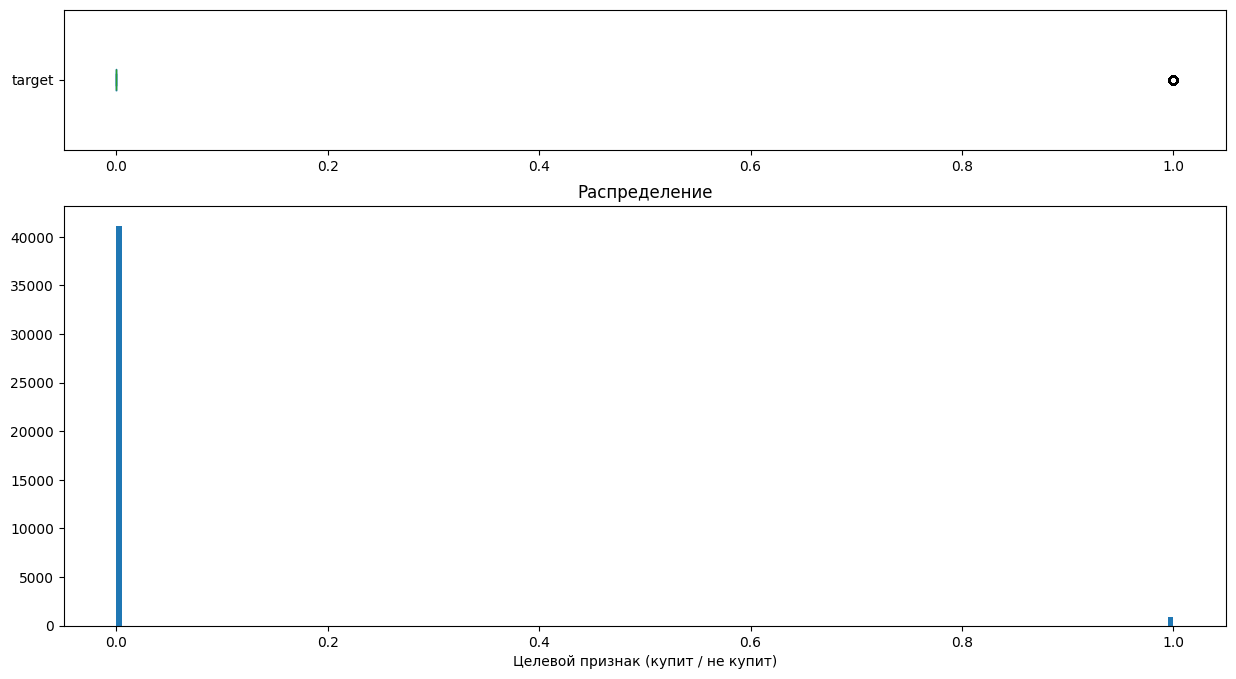

---------------------------------------------------------------------------------------------------------
 Поле : purchase_sum - Сумма покупок 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count     41982.000000
mean       4794.759707
std        7335.087586
min           1.000000
25%        1499.000000
50%        2866.000000
75%        5598.000000
max      540408.000000
Name: purchase_sum, dtype: float64


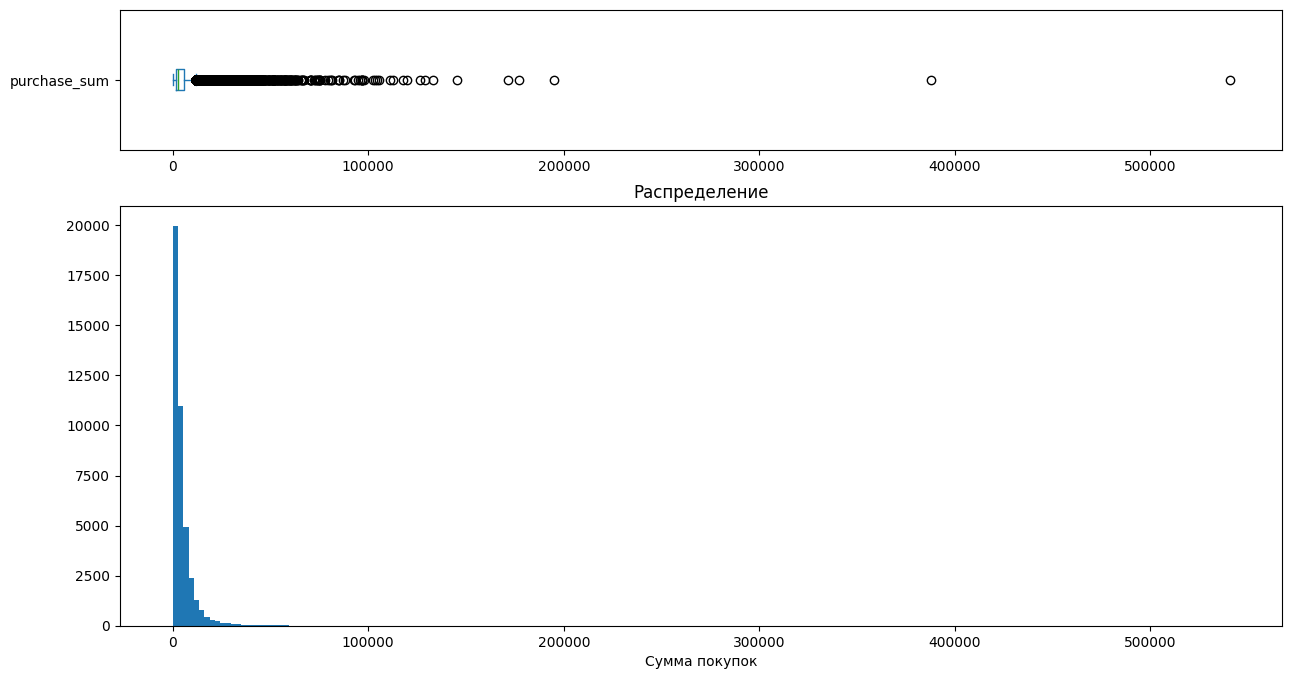

---------------------------------------------------------------------------------------------------------
 Поле : purchase_count - Количество покупок 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    41982.000000
mean         3.962055
std          5.304322
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        218.000000
Name: purchase_count, dtype: float64


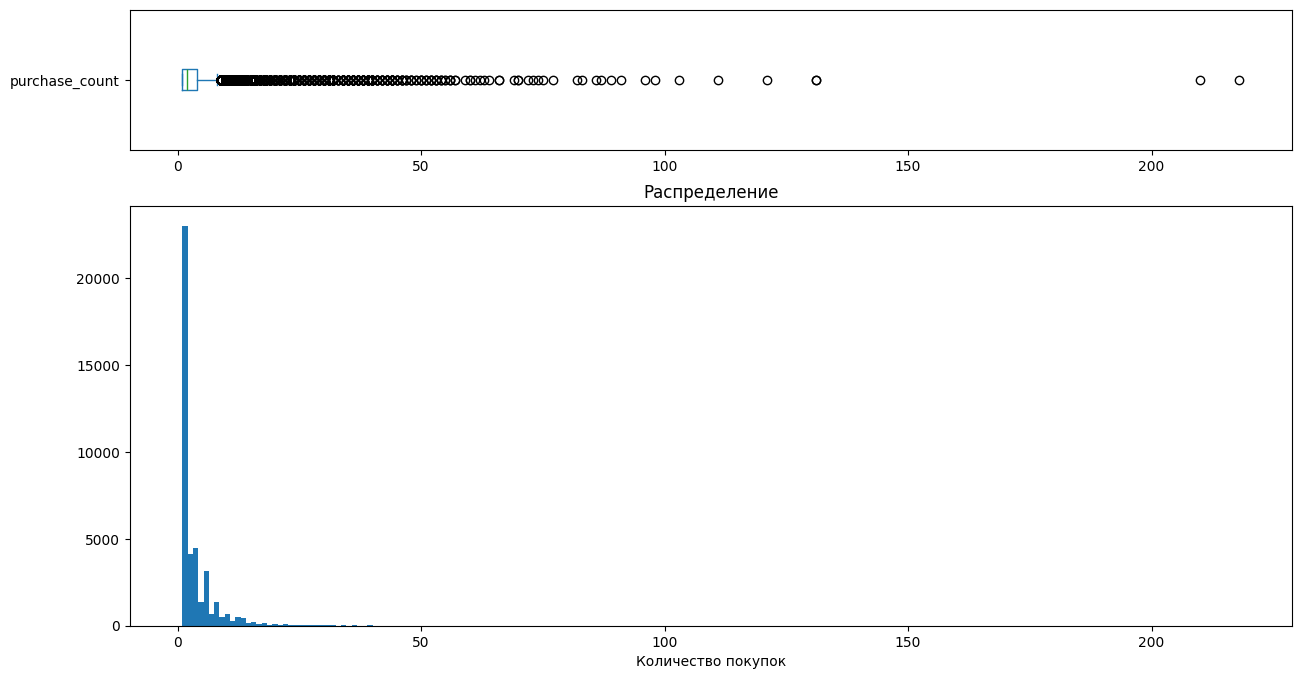

---------------------------------------------------------------------------------------------------------
 Поле : purchase - Количество покупок Mess 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    41982.000000
mean         1.371731
std          1.437177
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        103.000000
Name: purchase, dtype: float64


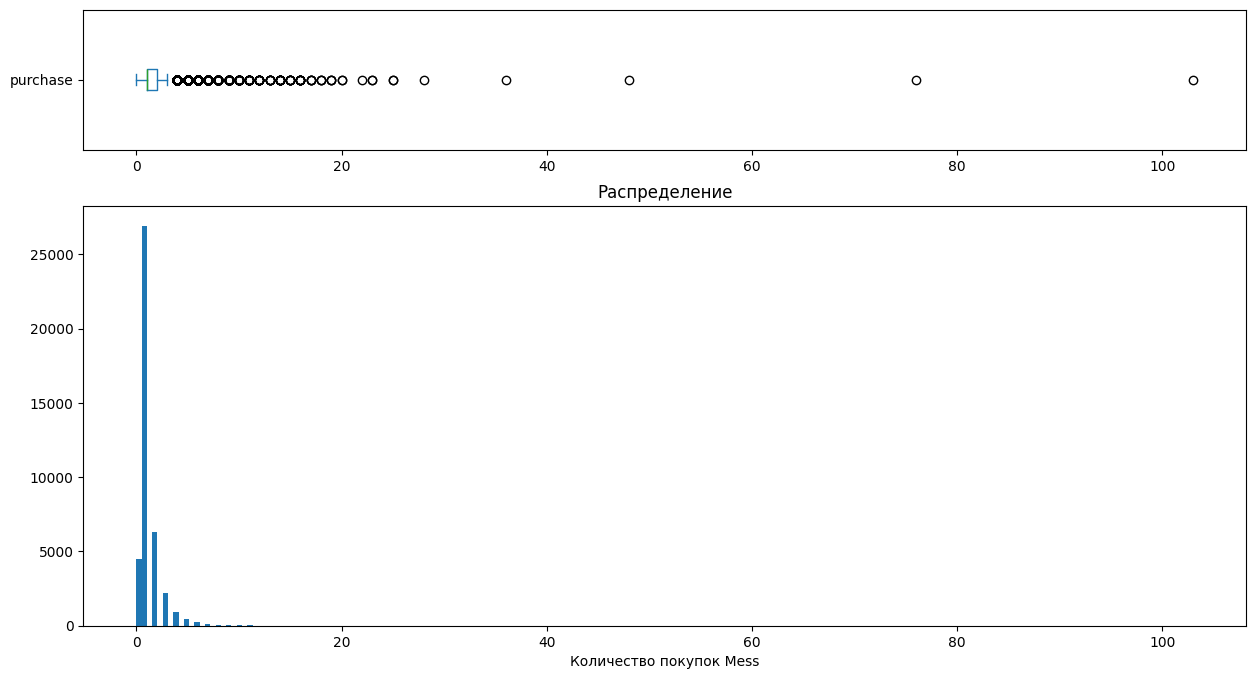

---------------------------------------------------------------------------------------------------------
 Поле : date_delta - Разница между первой 
 и последней покупкой 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    41982.000000
mean        22.767781
std         80.378258
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        636.000000
Name: date_delta, dtype: float64


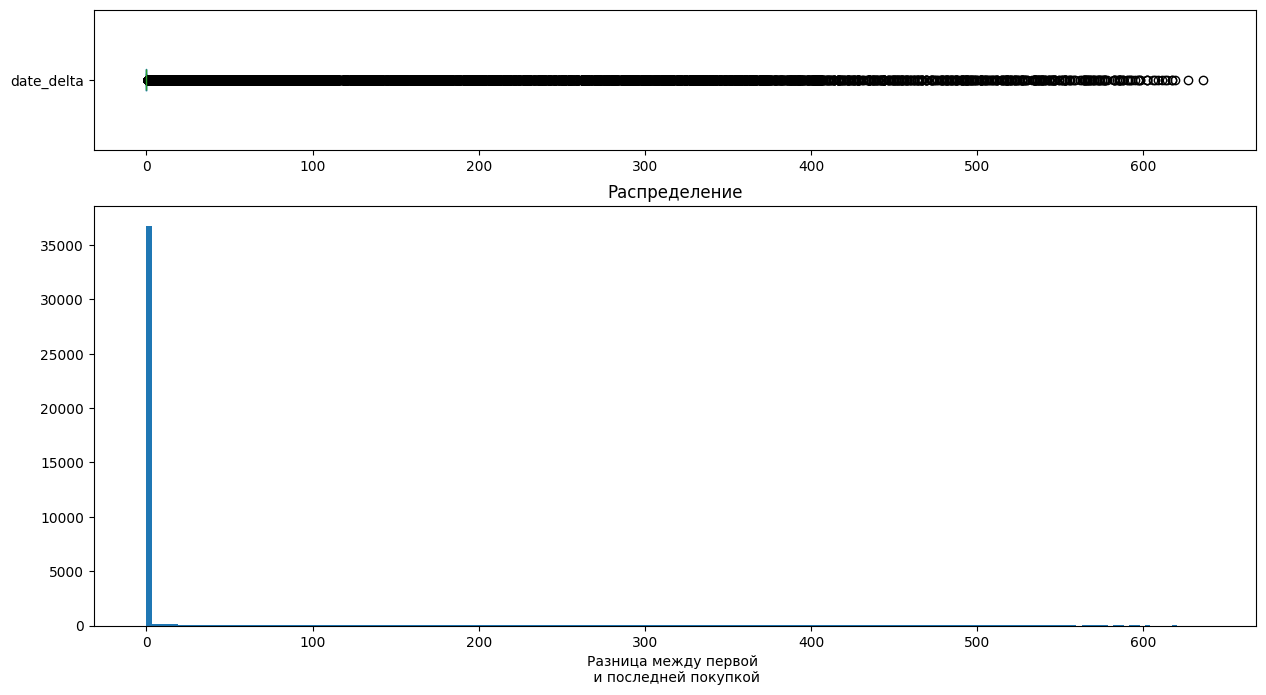

---------------------------------------------------------------------------------------------------------
 Поле : purchase_day_count - Количество дней с покупками 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    41982.000000
mean         1.219546
std          0.662135
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         23.000000
Name: purchase_day_count, dtype: float64


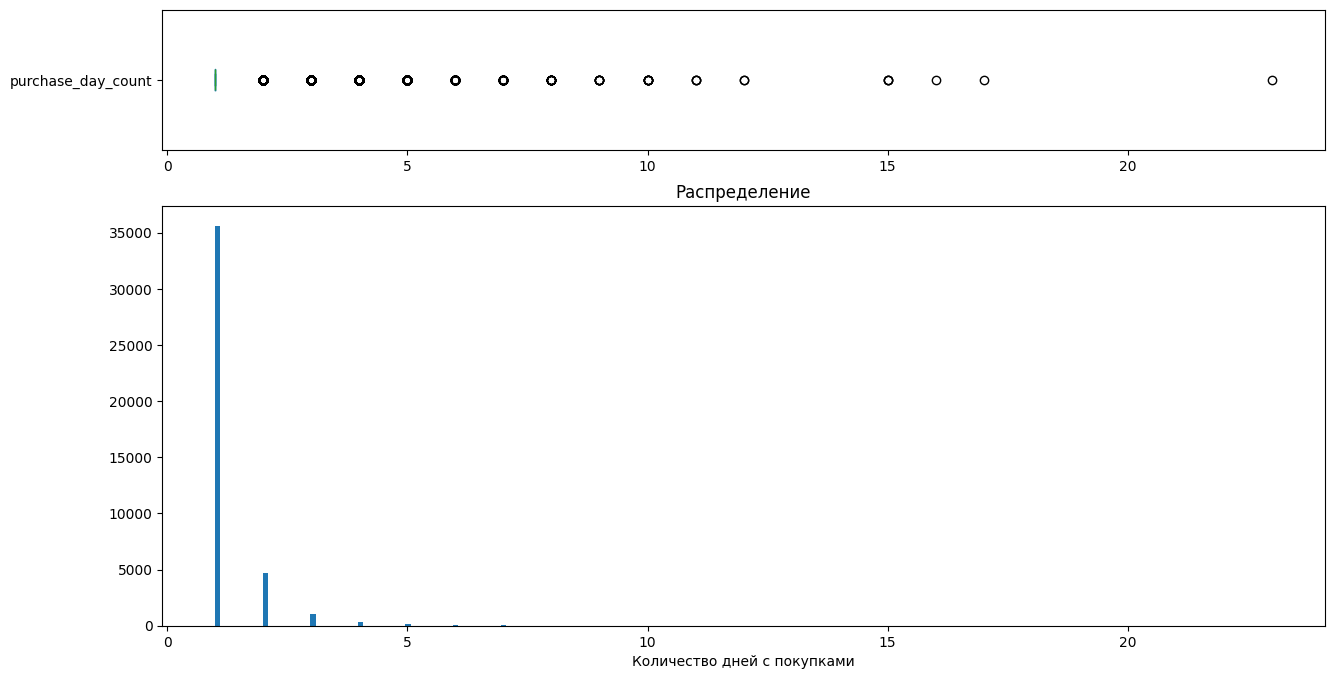

---------------------------------------------------------------------------------------------------------
 Поле : mean_purchase_period - Частота совершения покупок в днях 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    41982.000000
mean         9.189819
std         32.752772
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        310.000000
Name: mean_purchase_period, dtype: float64


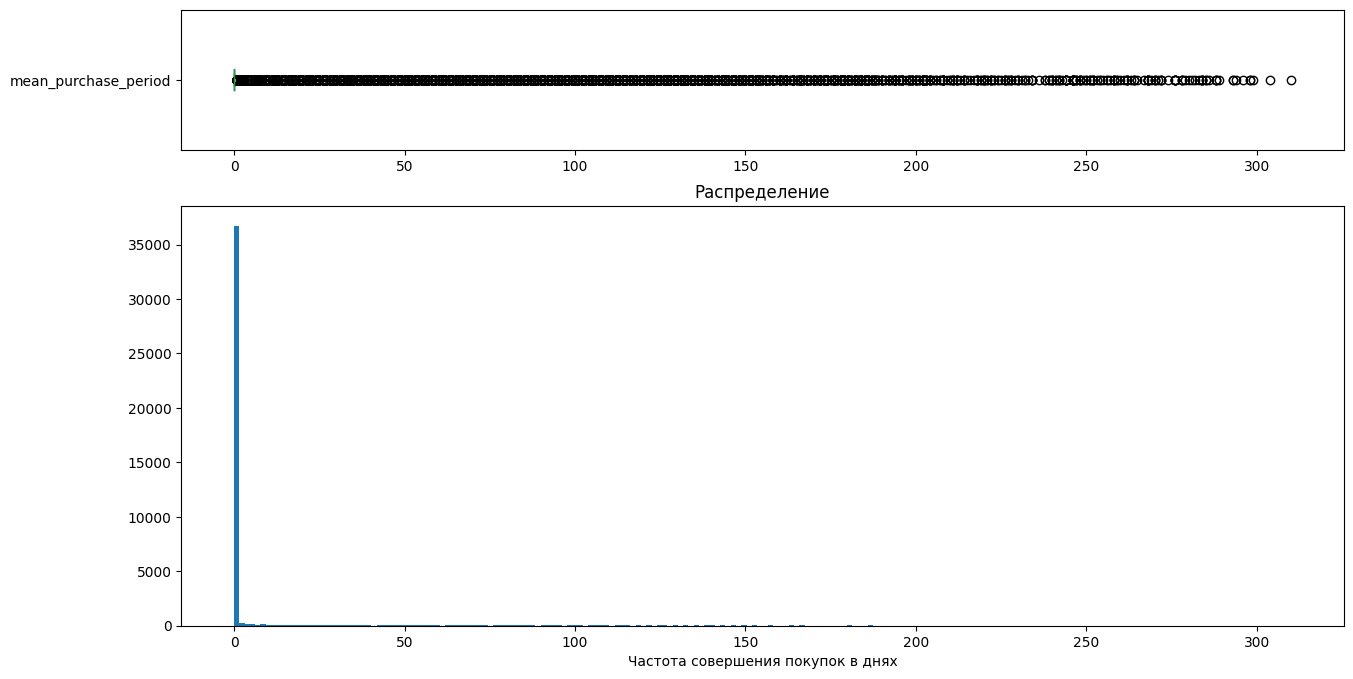

---------------------------------------------------------------------------------------------------------
 Поле : days_without_purchases - Количество дней после последней покупки 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    41982.000000
mean       372.304226
std        190.361630
min          0.000000
25%        236.000000
50%        388.000000
75%        558.000000
max        641.000000
Name: days_without_purchases, dtype: float64


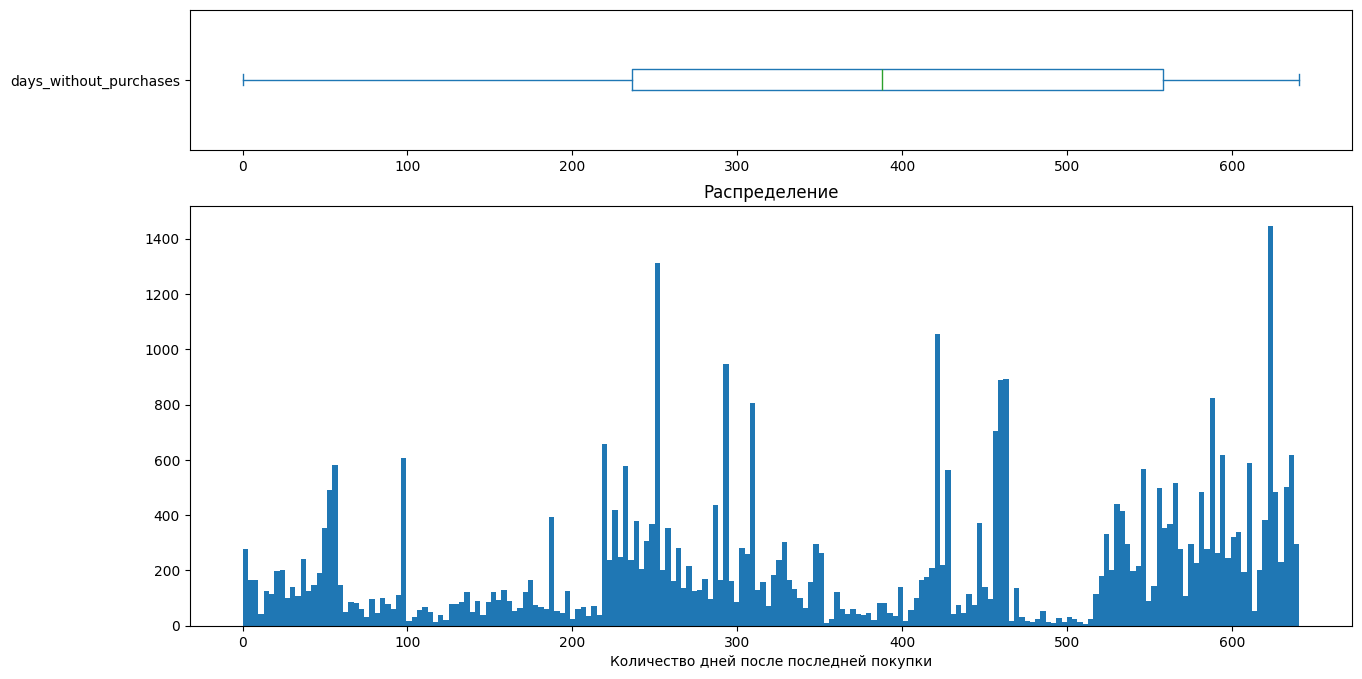

---------------------------------------------------------------------------------------------------------
 Поле : bulk_campaign_count - Количество рассылок 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    41982.000000
mean       186.284289
std        103.524484
min          1.000000
25%        114.000000
50%        174.000000
75%        257.000000
max       2465.000000
Name: bulk_campaign_count, dtype: float64


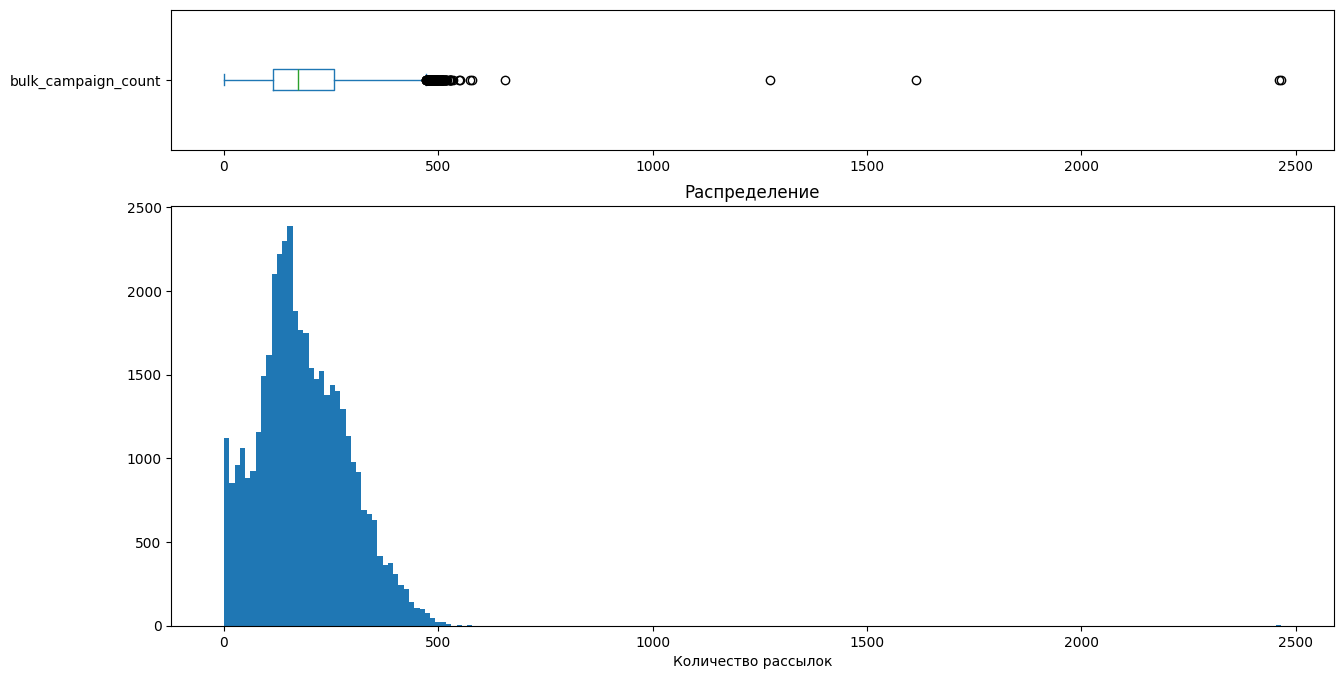

---------------------------------------------------------------------------------------------------------
 Поле : click - Количество кликов 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    41982.000000
mean        10.852318
std         14.164661
min          0.000000
25%          3.000000
50%          6.000000
75%         14.000000
max        384.000000
Name: click, dtype: float64


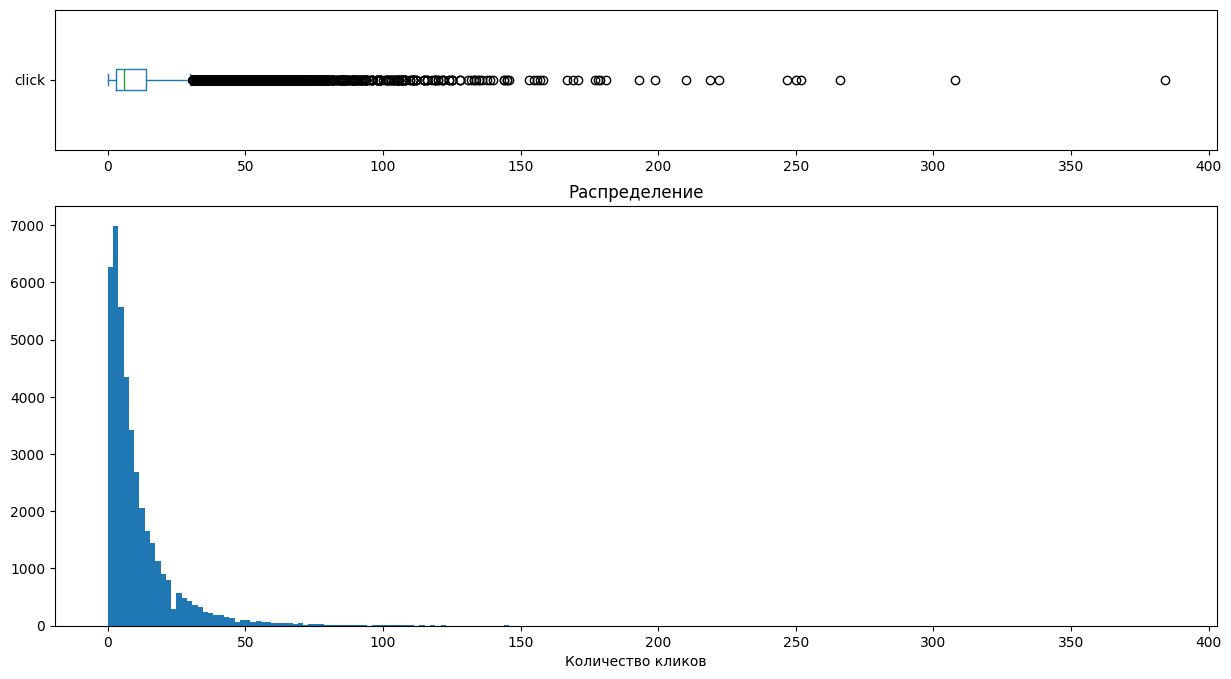

---------------------------------------------------------------------------------------------------------
 Поле : complain - Количество жалоб 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    41982.000000
mean         0.011815
std          0.489769
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         80.000000
Name: complain, dtype: float64


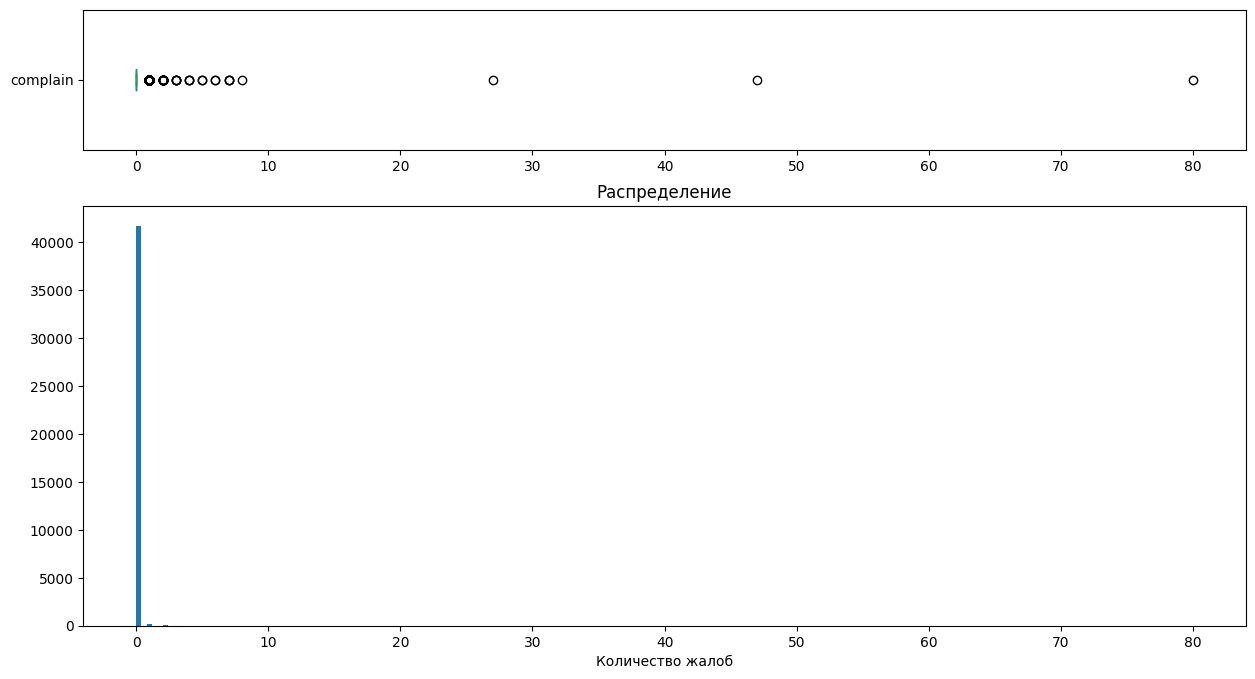

---------------------------------------------------------------------------------------------------------
 Поле : open - Количество открытых сообщений 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    41982.000000
mean        59.772450
std         74.921588
min          0.000000
25%          4.000000
50%         26.000000
75%         94.000000
max       1268.000000
Name: open, dtype: float64


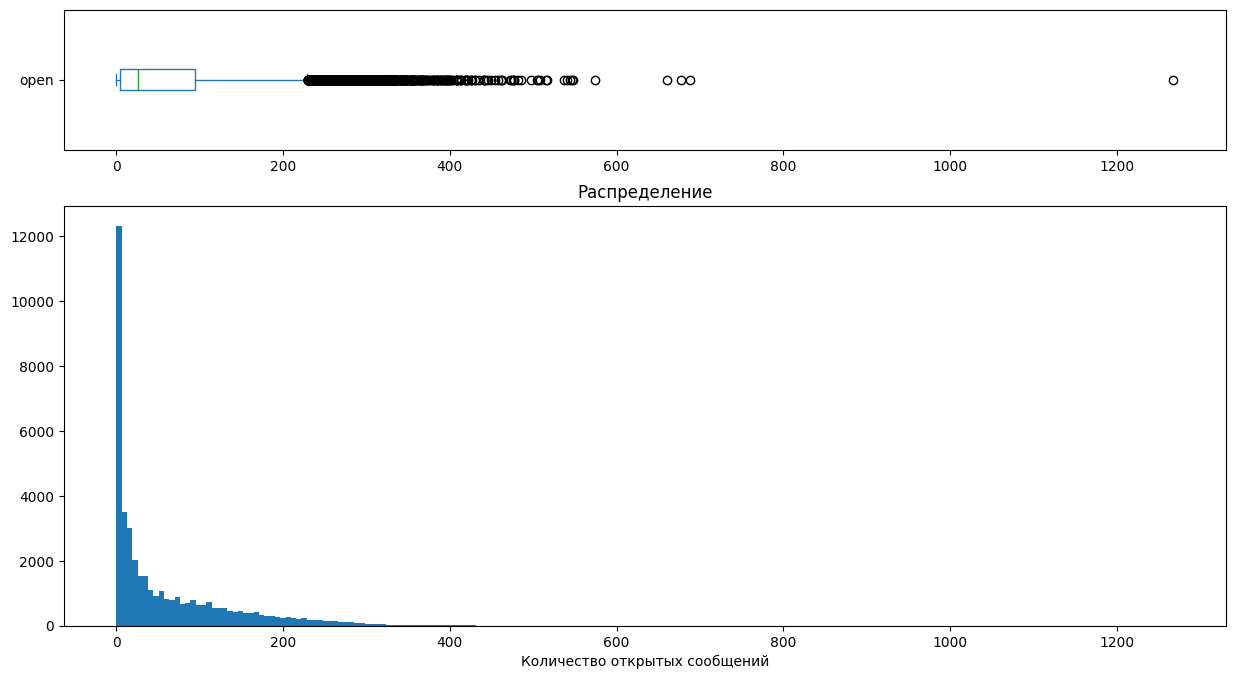

---------------------------------------------------------------------------------------------------------
 Поле : send - Количество сообщений по mess 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    41982.000000
mean       188.152470
std        104.649185
min          0.000000
25%        115.000000
50%        175.000000
75%        260.000000
max       2473.000000
Name: send, dtype: float64


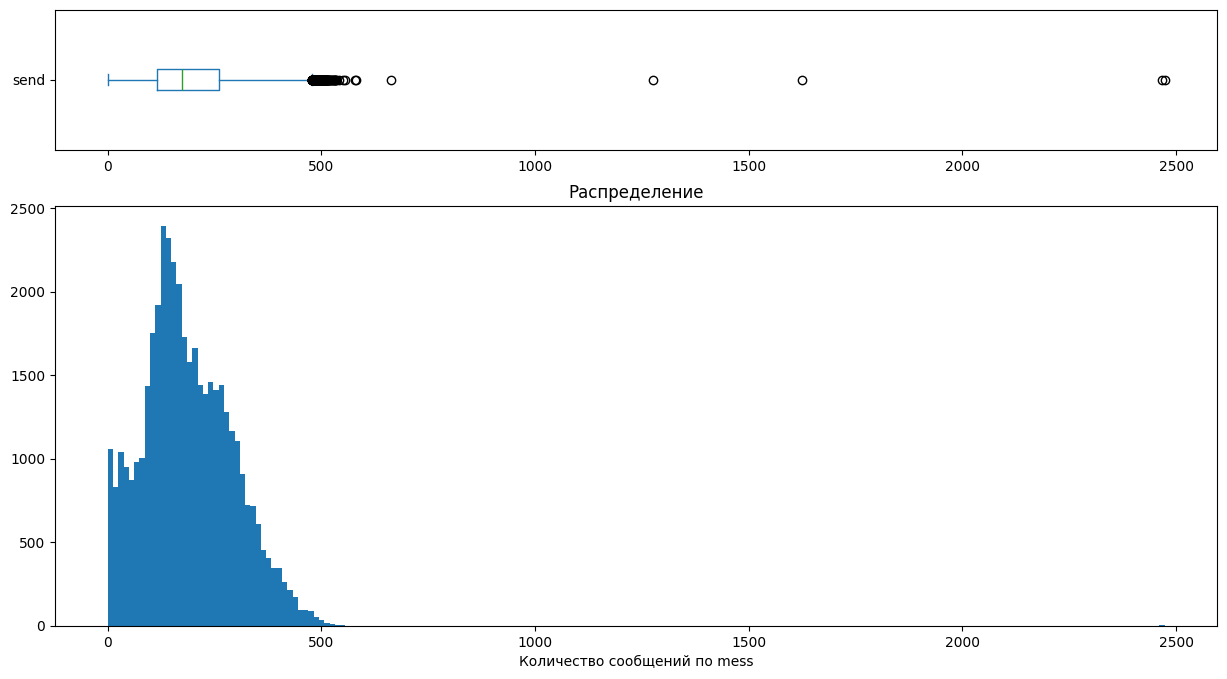

---------------------------------------------------------------------------------------------------------
 Поле : subscribe - Количество подписавшихся по mess 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    41982.000000
mean         0.001810
std          0.047285
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: subscribe, dtype: float64


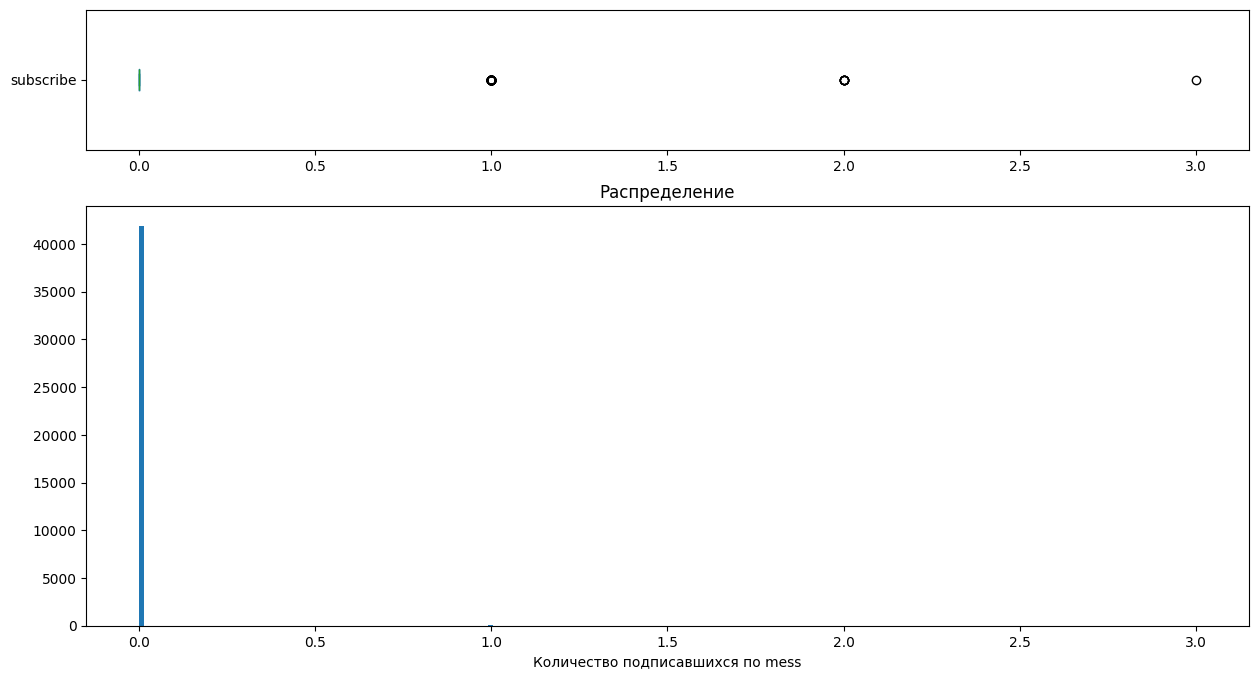

---------------------------------------------------------------------------------------------------------
 Поле : unsubscribe - Количество отписавшихся по mess 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    41982.000000
mean         0.062455
std          0.315328
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: unsubscribe, dtype: float64


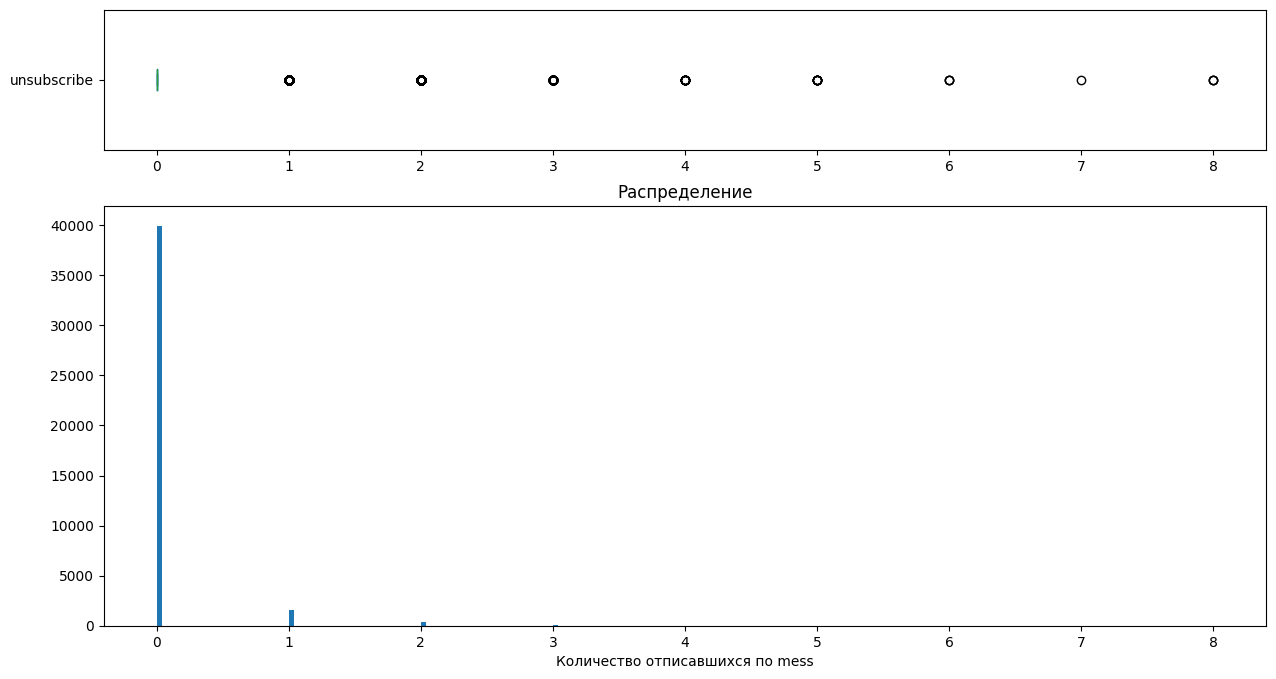

---------------------------------------------------------------------------------------------------------
 Поле : negative_delivery_message - Количество недоставленных сообщений по mess 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    41982.000000
mean         0.622934
std          3.103086
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        134.000000
Name: negative_delivery_message, dtype: float64


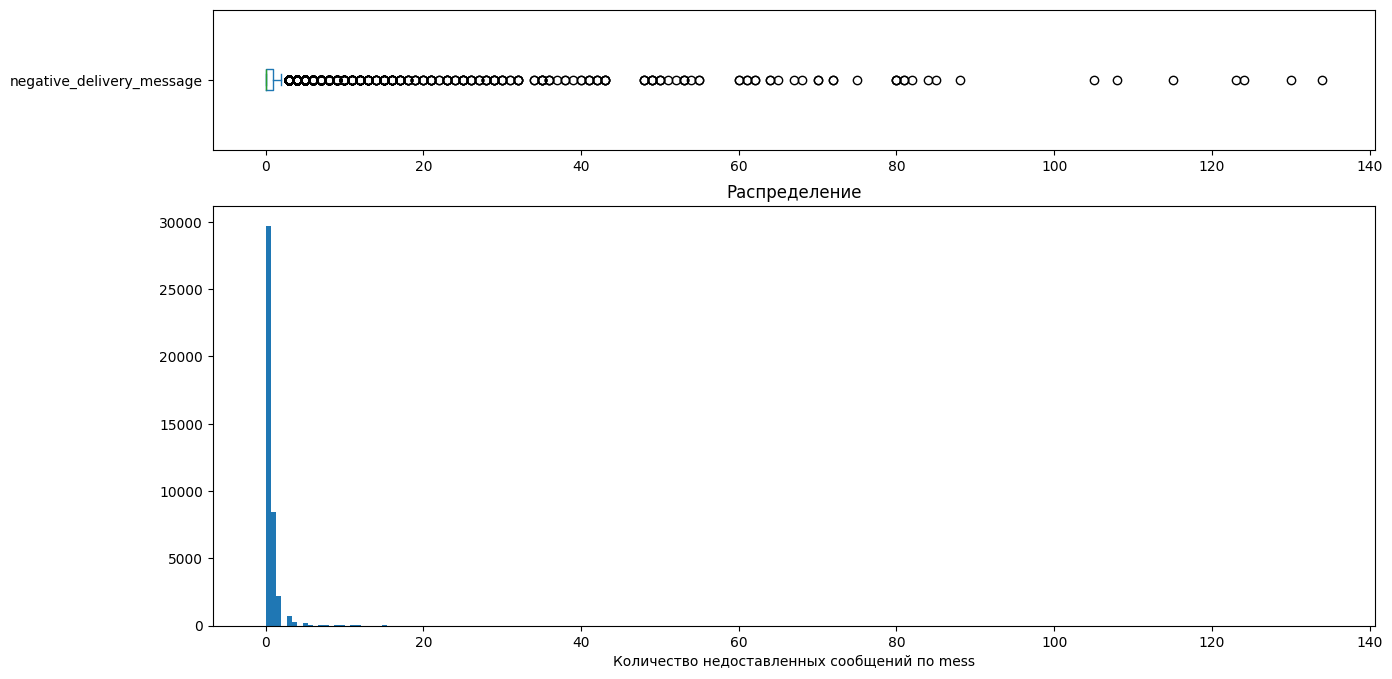

In [35]:
indexes = [
    'target',
    'purchase_sum',
    'purchase_count',
    'purchase',
    'date_delta',
    'purchase_day_count',
    'mean_purchase_period',
    'days_without_purchases',
    
    'bulk_campaign_count',
    'click',
    'complain',
    
    'open',
    'send',

    'subscribe',
    'unsubscribe',
    'negative_delivery_message'
]

titles = [
    'Целевой признак (купит / не купит)',
    'Сумма покупок',
    'Количество покупок',
    'Количество покупок Mess',
    'Разница между первой \n и последней покупкой',
    'Количество дней с покупками',
    'Частота совершения покупок в днях',
    'Количество дней после последней покупки',
    
    'Количество рассылок',
    'Количество кликов',
    'Количество жалоб',
    
    'Количество открытых сообщений',
    'Количество сообщений по mess',

    'Количество подписавшихся по mess',
    'Количество отписавшихся по mess',
    'Количество недоставленных сообщений по mess'
]

index = 0
for column in indexes:
    column_analiser(
        client_info_df,
        column,
        x_label = titles[index],
        y_label = '',
        print_unique = False,
        bins_= 200,
        figsize_ = (15, 8),
        height_ratios_ = [1, 3],
        hue_lst_ = [], #hue_lst,
        kde_plot_log_flag_ = [], #kde_plot_log_flag[index],
        kde_plot_figsize_ = (15, 4),
        kde_plot_title = '',
        kde_plot_x_label = titles[index],
        kde_plot_y_label = 'Распределение.'
)
    index += 1

### Удаление аномалий

In [36]:
client_info_df = client_info_df.loc[client_info_df['bulk_campaign_count'] <= 500]
#client_info_df = client_info_df.loc[client_info_df['purchase_sum'] <= 100000]
#client_info_df = client_info_df.loc[client_info_df['open'] <= 400]

In [37]:
client_info_df.info()
display(client_info_df.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 41936 entries, 0 to 49844
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   client_id                  41936 non-null  int64  
 1   purchase_count             41936 non-null  int32  
 2   purchase_sum               41936 non-null  float64
 3   date_delta                 41936 non-null  int32  
 4   days_without_purchases     41936 non-null  int32  
 5   purchase_day_count         41936 non-null  int32  
 6   mean_purchase_period       41936 non-null  int32  
 7   bulk_campaign_count        41936 non-null  int32  
 8   target                     41936 non-null  int32  
 9   click                      41936 non-null  int32  
 10  complain                   41936 non-null  int32  
 11  open                       41936 non-null  int32  
 12  purchase                   41936 non-null  int32  
 13  send                       41936 non-null  int32  


Index(['client_id', 'purchase_count', 'purchase_sum', 'date_delta',
       'days_without_purchases', 'purchase_day_count', 'mean_purchase_period',
       'bulk_campaign_count', 'target', 'click', 'complain', 'open',
       'purchase', 'send', 'subscribe', 'unsubscribe',
       'negative_delivery_message'],
      dtype='object')

### **`Выводы :`**

* Сформирован DataFrame - `client_info_df`, содержащий агрегированную информацию по клиенту - `client_id`:
|Field Name| Расшифровка|
|------------|--------------------------|
|**client_id**|идентификатор клиента|
|**purchase_count**|количество покупок|
|**purchase_sum**|сумма покупок|
|**date_delta**|количество дней между первой и последней покупкой|
|**days_without_purchases**|количество дней между последней покупкой клиента и последней покупкой в магазине|
|**purchase_day_count**|количество дней с покупками|
|**mean_purchase_period**|частота покупок(Среднее значение периода без покупок)|
|**bulk_campaign_count**|количество рассылок|
|**target**|целевой признак (купит/не купит)|
|**click**|клики|
|**complain**|жалобы|
|**open**|открытия сообщений|
|**purchase**|покупки|
|**send**|отправки сообщений|
|**subscribe**|клиент подписался|
|**unsubscribe**|клиент отписался от рассылки|
|**negative_delivery_message**|письма не доставлены|br>


# Корреляционный анализ

In [38]:
# Формирование индекса по полю client_id
client_info_df.set_index('client_id', inplace = True)

In [39]:
indexes = [
    'purchase_count',
    'purchase_sum',
    'date_delta',
    'days_without_purchases',
    'purchase_day_count',
    'mean_purchase_period',
    'bulk_campaign_count',
    'target',
    'click',
    'complain',
    'open',
    'purchase',
    'send',
    'subscribe',
    'unsubscribe',
    'negative_delivery_message'
]

ml_df = client_info_df[indexes]

CPU times: total: 266 ms
Wall time: 277 ms


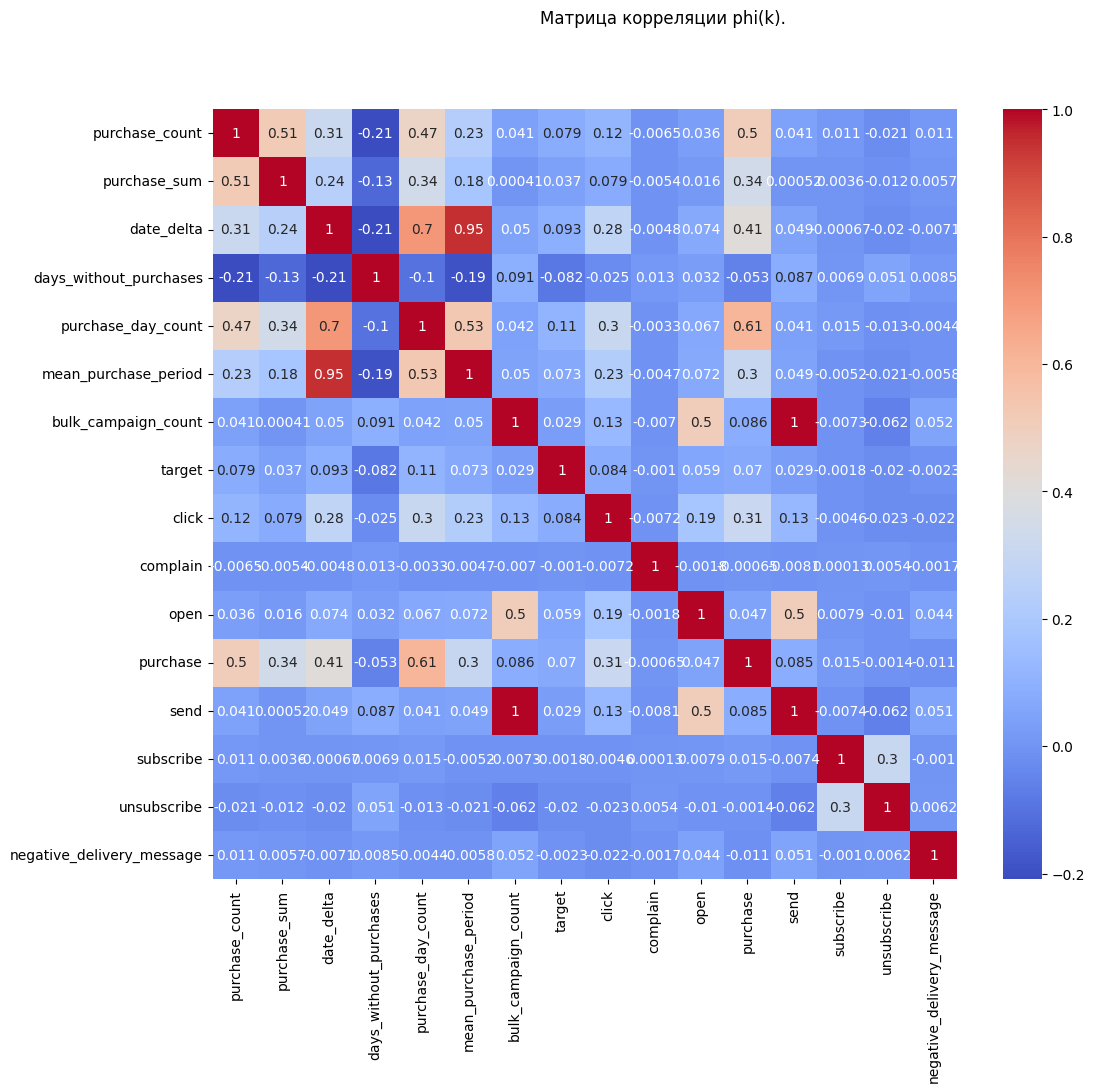

In [40]:
%%time

plt.figure(figsize = (12, 10))
plt.suptitle('Матрица корреляции phi(k).')

sns.heatmap(
#    client_info_df.phik_matrix(interval_cols = indexes), annot=True, cmap='coolwarm'
    ml_df.corr(), annot=True, cmap='coolwarm'
);

In [41]:
# Коэффициент корреляции date_delta и mean_purchase_period = 0.95
# Коэффициент корреляции send и bulk_campaign_count = 1
# Для исключения мультиколлинеарности удалены поля date_delta и send

indexes = [
    'target',
    'purchase_count',
    'purchase',
    'purchase_sum',
#    'date_delta',
    'purchase_day_count',
    'days_without_purchases', #
    'mean_purchase_period',
    
    'bulk_campaign_count', #
    'click',
    'complain',#
    
    'open',
    #'send',

    'subscribe',#
    'unsubscribe',#
    'negative_delivery_message'
]

ml_df = client_info_df[indexes]

CPU times: total: 250 ms
Wall time: 240 ms


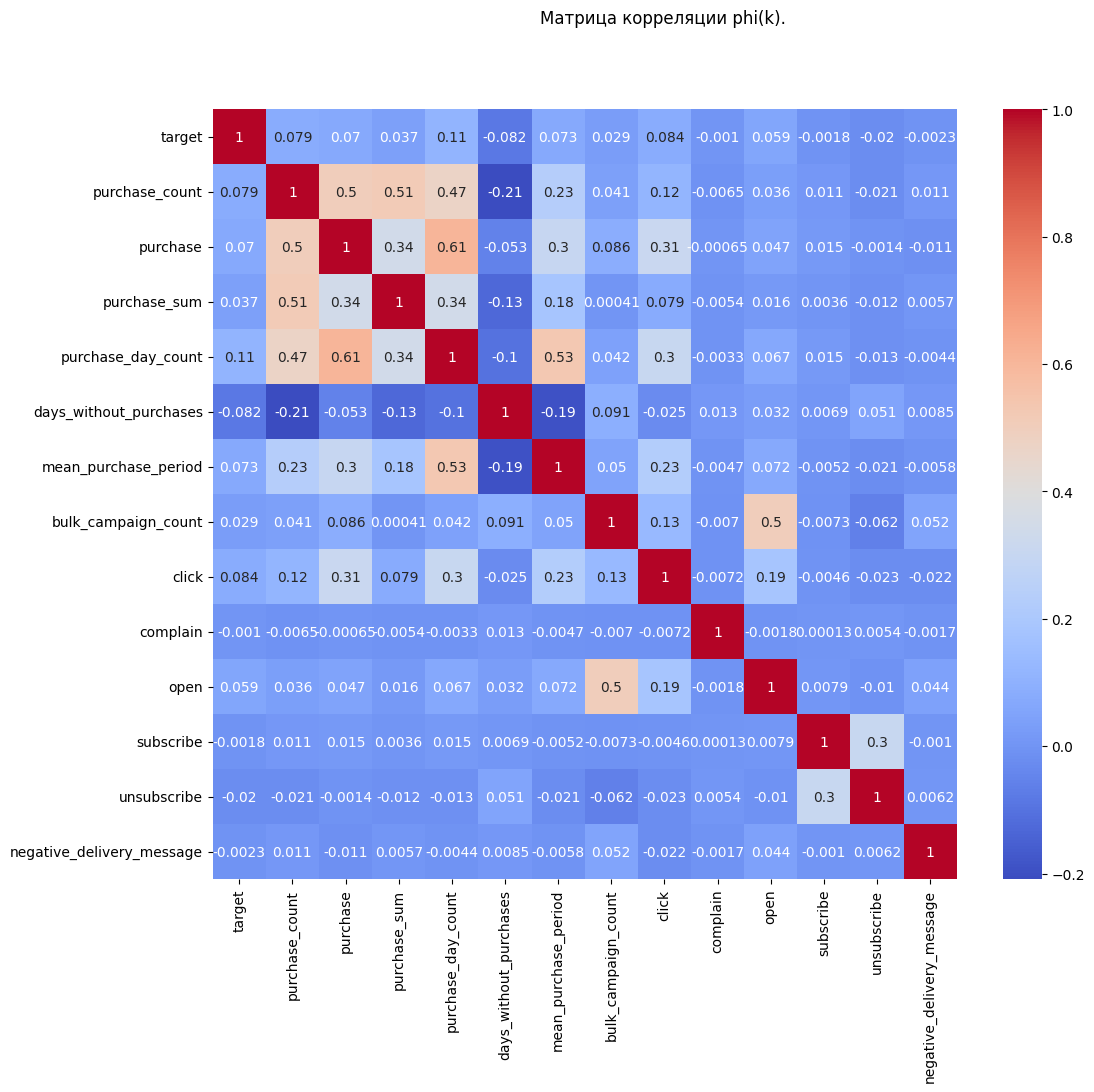

In [42]:
%%time

plt.figure(figsize = (12, 10))
plt.suptitle('Матрица корреляции phi(k).')

sns.heatmap(
#    client_info_df.phik_matrix(interval_cols = indexes), annot=True, cmap='coolwarm'
    ml_df.corr(), annot=True, cmap='coolwarm'
);

In [43]:
ml_df.name = 'ml_df'
duplicates_df, ml_df__original_shape = df_inf(df = ml_df, head_row = 3, drop_duplicates_flag = True)

 ------------------------------------------------------------------------------------------------------------------------------------- 
 Имя: ml_df 

 ml_df (первые 3 строк) 


,target,purchase_count,purchase,purchase_sum,purchase_day_count,days_without_purchases,mean_purchase_period,bulk_campaign_count,click,complain,open,subscribe,unsubscribe,negative_delivery_message
client_id,,,,,,,,,,,,,,
1515915625468060902,0,7,5,6993.0,1,630,0,127,10,0,35,0,1,0
1515915625468061003,1,7,1,16235.0,1,408,0,154,6,0,5,0,0,0
1515915625468061099,0,1,0,299.0,1,640,0,215,8,0,51,0,0,2



 Информация:  
<class 'pandas.core.frame.DataFrame'>
Index: 41936 entries, 1515915625468060902 to 1515915626010261344
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   target                     41936 non-null  int32  
 1   purchase_count             41936 non-null  int32  
 2   purchase                   41936 non-null  int32  
 3   purchase_sum               41936 non-null  float64
 4   purchase_day_count         41936 non-null  int32  
 5   days_without_purchases     41936 non-null  int32  
 6   mean_purchase_period       41936 non-null  int32  
 7   bulk_campaign_count        41936 non-null  int32  
 8   click                      41936 non-null  int32  
 9   complain                   41936 non-null  int32  
 10  open                       41936 non-null  int32  
 11  subscribe                  41936 non-null  int32  
 12  unsubscribe                41936 non-null  int32  
 13  neg

,target,purchase_count,purchase,purchase_sum,purchase_day_count,days_without_purchases,mean_purchase_period,bulk_campaign_count,click,complain,open,subscribe,unsubscribe,negative_delivery_message
count,41936.000000,41936.000000,41936.000000,41936.000000,41936.000000,41936.000000,41936.000000,41936.000000,41936.000000,41936.000000,41936.000000,41936.000000,41936.000000,41936.000000
mean,0.020102,3.960630,1.371495,4795.516549,1.219597,372.274919,9.196871,185.779950,10.842689,0.011828,59.563788,0.001765,0.062357,0.621829
std,0.140351,5.300612,1.436809,7337.515110,0.662198,190.331876,32.767753,101.447259,14.114358,0.490037,74.423561,0.046293,0.314808,3.099424
min,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1499.000000,1.000000,236.000000,0.000000,114.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,1.000000,2866.500000,1.000000,388.000000,0.000000,174.000000,6.000000,0.000000,26.000000,0.000000,0.000000,0.000000
75%,0.000000,4.000000,2.000000,5598.000000,1.000000,558.000000,0.000000,256.000000,14.000000,0.000000,94.000000,0.000000,0.000000,1.000000
max,1.000000,218.000000,103.000000,540408.000000,23.000000,641.000000,310.000000,500.000000,384.000000,80.000000,688.000000,3.000000,8.000000,134.000000



 Описание не числовых полей:  
 Не числовых полей нет! 

 Пропуски:  


target                       0
purchase_count               0
purchase                     0
purchase_sum                 0
purchase_day_count           0
days_without_purchases       0
mean_purchase_period         0
bulk_campaign_count          0
click                        0
complain                     0
open                         0
subscribe                    0
unsubscribe                  0
negative_delivery_message    0
dtype: int64


 Доля записей, содержащих пропуски:  0.0 %
 
 Количество дубликатов: 2 
 Дубликаты (первые 3 строк) 


,target,purchase_count,purchase,purchase_sum,purchase_day_count,days_without_purchases,mean_purchase_period,bulk_campaign_count,click,complain,open,subscribe,unsubscribe,negative_delivery_message
client_id,,,,,,,,,,,,,,
1515915625489218166,0,2,1,3498.0,1,462,0,134,2,0,4,0,0,0
1515915625793207814,0,1,1,1999.0,1,635,0,2,1,0,0,0,0,0


 Дубликаты удалены! 
 Количество дубликатов после удаления: 0 
 


## **`Выводы :`**
* Для определения модели  и проведении дальнейшего анализа, по аналогии с `client_info_df`, сформирован DataFrame - **`ml_df`**
* Корреляционный анализ показал высокую зависимость значений признаков:
    * Коэффициент корреляции `date_delta` и `mean_purchase_period` = **0.95**
    * Коэффициент корреляции `send` и `bulk_campaign_count` = **1**
    * Для исключения мультиколлинеарности удалены поля `date_delta` и `send`

# Обучение

In [44]:
RANDOM_STATE = 45
TEST_SIZE = 0.25

# Формирование тренировочной и тестовой выборок
X_train, X_test, y_train, y_test = train_test_split(
    ml_df.drop(['target'], axis = 1),
    ml_df['target'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = ml_df['target'])

# сэмплирование данных
# sampler = RandomOverSampler(random_state = RANDOM_STATE)
# sampler = RandomUnderSampler(random_state = RANDOM_STATE)

sampler = SMOTE(
    sampling_strategy = 0.7, #'auto',  # Стратегия выборки. 'auto' означает увеличение меньшего класса до размера большинственного.
    random_state = RANDOM_STATE,       # Зерно для генератора случайных чисел.
    k_neighbors = 5,                   # Количество ближайших соседей для создания синтетических примеров.
    n_jobs = 1                         # Количество ядер для параллельной работы. -1 означает использование всех доступных ядер.
)

X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)
X_test_sampled, y_test_sampled = sampler.fit_resample(X_test, y_test)

# Тренировочная выборка до и после сэмплирования
print(blue_start, 'Тренировочные данные до сэмплирования :\n', color_end, y_train.value_counts())
print(blue_start, 'Тренировочные данные после сэмплирования :\n', color_end, y_train_sampled.value_counts())
print('')

# Тестовая выборка до и после сэмплирования
print(blue_start, 'Тестовые данные до сэмплирования :\n', color_end, y_test.value_counts())
print(blue_start, 'Тестовые данные после сэмплирования :\n', color_end, y_test_sampled.value_counts())

 Тренировочные данные до сэмплирования :
  target
0    30818
1      632
Name: count, dtype: int64
 Тренировочные данные после сэмплирования :
  target
0    30818
1    21572
Name: count, dtype: int64

 Тестовые данные до сэмплирования :
  target
0    10273
1      211
Name: count, dtype: int64
 Тестовые данные после сэмплирования :
  target
0    10273
1     7191
Name: count, dtype: int64


In [45]:
# num_columns - список масштабируемых полей, не содержит поле target

num_columns = [
    'purchase_count',
    'purchase',
    'purchase_sum',
    'purchase_day_count',
    'days_without_purchases',
    'mean_purchase_period',
    'bulk_campaign_count',
    'click',
    'complain',
    'open',
    'subscribe',
    'unsubscribe',
    'negative_delivery_message'
]

In [46]:
%%time

data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# Основной пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))
])

# Определение параметров для поиска
param_dist = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [CatBoostClassifier(verbose=0, random_state = RANDOM_STATE)],
        'models__iterations': [50],
        'models__depth': [3, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50],
        'models__max_depth': [3, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },    
    {
        'models': [XGBClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50],
        'models__max_depth': [3, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

search = RandomizedSearchCV(
    pipe_final,
    param_distributions = param_dist,
    n_iter = 100,
    cv = 3,
    verbose = 3,
    scoring = 'roc_auc',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

search.fit(X_train_sampled, y_train_sampled)

Fitting 3 folds for each of 88 candidates, totalling 264 fits
CPU times: total: 5.34 s
Wall time: 1min 4s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['purchase_count',
                                                                                'purchase',
                                                                                'purchase_sum',
                                                                                'purchase_day_count',
                                                                                'days_without_purchases',
                                                                                'mean_purchase_period',
                                                                                'bulk_campaign_count',
                                                                                'click',
                                                                                'complain',
                                                                                'open',
                                                                                'subscribe',
                                                                                'unsubscribe',
                                                                                'negative_deliver...
                                                                  max_leaves=None,
                                                                  min_child_weight=None,
                                                                  missing=nan,
                                                                  monotone_constraints=None,
                                                                  multi_strategy=None,
                                                                  n_estimators=None,
                                                                  n_jobs=None,
                                                                  num_parallel_tree=None,
                                                                  random_state=45, ...)],
                                         'models__max_depth': [3, 5],
                                         'models__n_estimators': [50],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=45, scoring='roc_auc', verbose=3)

In [47]:
# Результаты валидации
cv_results = pd.DataFrame(search.cv_results_)
cols = [
'param_models',
'params',
'mean_fit_time',
'std_fit_time',
'mean_score_time',
'std_score_time',
'split0_test_score',
'split1_test_score',
'split2_test_score',
'mean_test_score',
'std_test_score',
'rank_test_score'
]

In [48]:
# Три лучшие модели
cv_results[cols].sort_values('rank_test_score').head(3)

,param_models,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
63,KNeighborsClassifier(),"{'preprocessor__num': 'passthrough', 'models__n_neighbors': 4, 'models': KNeighborsClassifier()}",0.567752,0.053418,0.779665,0.067488,0.956506,0.959712,0.959076,0.958431,0.001386,1
59,KNeighborsClassifier(),"{'preprocessor__num': 'passthrough', 'models__n_neighbors': 3, 'models': KNeighborsClassifier()}",0.504299,0.036871,0.657156,0.065687,0.954199,0.957153,0.957347,0.956233,0.001440,2
55,KNeighborsClassifier(),"{'preprocessor__num': 'passthrough', 'models__n_neighbors': 2, 'models': KNeighborsClassifier()}",0.455142,0.010192,0.567113,0.024433,0.949003,0.951330,0.952015,0.950782,0.001289,3


In [49]:
print(blue_start, 'Лучшая модель и её параметры :\n\n', color_end, search.best_estimator_, '\n')
print(blue_start, 'Метрика лучшей модели на кросс-валидации:', color_end, round(search.best_score_, 5))

 Лучшая модель и её параметры :

  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['purchase_count', 'purchase',
                                                   'purchase_sum',
                                                   'purchase_day_count',
                                                   'days_without_purchases',
                                                   'mean_purchase_period',
                                                   'bulk_campaign_count',
                                                   'click', 'complain', 'open',
                                                   'subscribe', 'unsubscribe',
                                                   'negative_delivery_message'])])),
                ('models', KNeighborsClassifier(n_neighbors=4))]) 

 Метрика лучшей модели на кросс-валидации

### *`Выводы :`*

* Данные целевого признак `target` не сбалансированны. Для минимизации влияния дисбаланса на качество модели былы сгенерированы синтетических данные. Для генерации использовался **SMOTE(sampling_strategy = 0.7**.
    * Результаты сэмплирования:
        * Тренировочные данные до сэмплирования (количество записей) : Класс 0 - 30818, Класс 1 - 632
        * Тренировочные данные после сэмплирования (количество записей) : Класс 0 - 30818, Класс 1 - 21572
        * Тестовые данные до сэмплирования :  Класс 0 - 10273, Класс 1 - 211
        * Тестовые данные после сэмплирования : Класс 0 - 10273, Класс 1 - 7191
* Модели, исследованные на на этапе кросс-валидации:
    * `LogisticRegression`
    * `DecisionTreeClassifier`
    * `KNeighborsClassifier`
    * `CatBoostClassifier`
    * `LGBMClassifier`
    * `XGBClassifier`
* Лучшая модель - `KNeighborsClassifier(n_neighbors=4)`
* Метрика лучшей модели на кросс-валидации:  `roc_auc` = **0.95843**

# Метрики и прогноз по тестовой выборке

In [50]:
# Обучение лучшей модели на тестовой выборке
best_param_model = KNeighborsClassifier(n_neighbors = 4).fit(X_test_sampled, y_test_sampled)

# Обучение лучшей модели на тесте
y_test_predict = best_param_model.predict(X_test_sampled)
y_test_predict_proba = best_param_model.predict_proba(X_test_sampled)

# Расчет метрик на тестовой выборке
# Метрика Accuracy (точность) показывает долю правильно классифицированных объектов относительно общего числа объектов в наборе данных. 1
# Она принимает значения в диапазоне от 0 до 1 (или от 0% до 100%). Чем ближе значение Accuracy к 1 (или 100%), тем лучше работает алгоритм классификации.
acc = accuracy_score(y_test_sampled, y_test_predict)
print(blue_start, 'Accuracy = ', color_end, round(acc, 4))

# Значение ROC-AUC колеблется от 0 до 1. 1 соответствует идеальному классификатору
roc_auc = roc_auc_score(y_test_sampled, y_test_predict)
print(blue_start, 'ROC-AUC =', color_end, round(roc_auc, 4))

# Метрика F1 (F-мера) показывает, насколько хорошо модель распознаёт положительные случаи, минимизируя ошибочно положительные и ошибочно отрицательные предсказания.
f1 = f1_score(y_test_sampled, y_test_predict, pos_label = 1)
print(blue_start, 'F1 =', color_end, round(f1, 4)) 

# Метрика Recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашёл алгоритм.
recall = recall_score(y_test_sampled, y_test_predict, pos_label = 1)
print(blue_start, 'Recall =', color_end, round(recall, 4))

# Precision (точность) показывает: сколько реальных объектов класса среди всех тех, что классификатор отнес к этому классу.
precision = precision_score(y_test_sampled, y_test_predict, pos_label = 1)
print(blue_start, 'Precision =', color_end, round(precision, 4))

 Accuracy =   0.9524
 ROC-AUC =  0.9542
 F1 =  0.9435
 Recall =  0.9644
 Precision =  0.9234


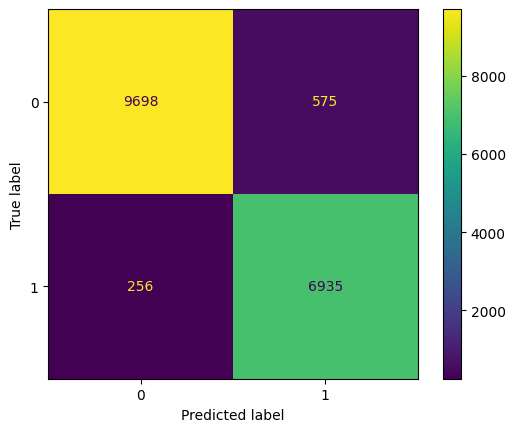

In [51]:
# Матрица ошибок
cm = confusion_matrix(y_test_sampled, y_test_predict)
cmp = ConfusionMatrixDisplay(cm, display_labels=["0", "1"])
cmp.plot();

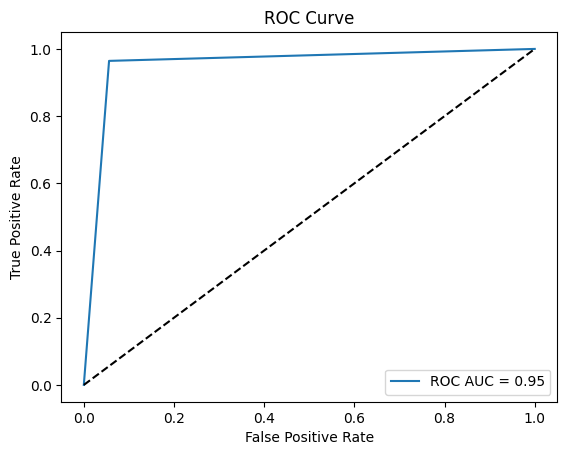

In [52]:
fpr, tpr, thresholds = roc_curve(y_test_sampled, y_test_predict)

plt.plot(fpr, tpr, label = f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Случайные предсказания
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Значимость признаков

In [53]:
%%time
result = permutation_importance(best_param_model, X_test_sampled, y_test_sampled, scoring = 'roc_auc')

CPU times: total: 14 s
Wall time: 14.1 s


,Feature,Importance
2,purchase_sum,4.382243e-01
4,days_without_purchases,3.003956e-01
6,bulk_campaign_count,2.043766e-01
9,open,1.428472e-01
5,mean_purchase_period,1.477933e-02
7,click,2.197496e-03
0,purchase_count,1.399751e-04
12,negative_delivery_message,5.212043e-05
1,purchase,5.780179e-07
3,purchase_day_count,0.000000e+00


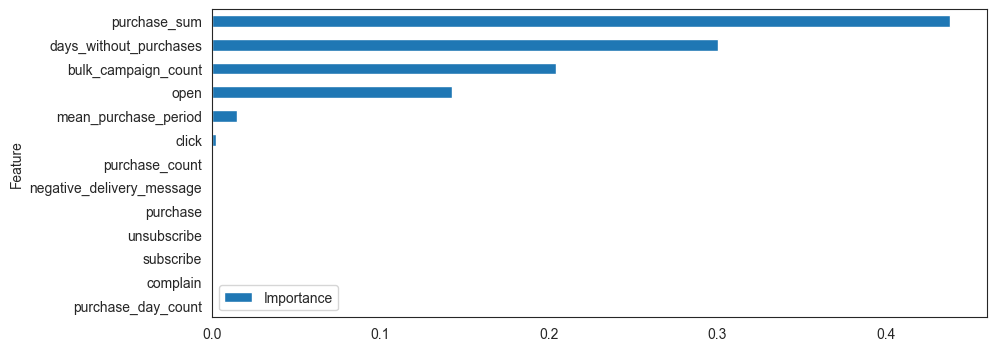

In [54]:
feature_importance = pd.DataFrame({'Feature': X_test_sampled.columns, 'Importance': result['importances_mean']})
display(feature_importance.sort_values('Importance', ascending = False))
feature_importance = feature_importance.sort_values('Importance', ascending = True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 4));

# **`Результаты проекта :`**

* Сформирован датасет для определения лучшей модели, определена лучшая модель
* Модель не идеальная, при этом значения метрик очень хорошие:
|**Метрика**|**Значение**|
|----------|-----------:|
|Accuracy|0.9524|
|ROC-AUC|0.9542|
|F1|0.9435|
|Recall|0.9644|
|Precision|0.9234|

<br>

* О высоком качестве модели можно судить по значениям Ложно положительных и Ложно отрицательных показателей (Матрица ошибок)
* Самые значимые показатели (в порядке убывания значимости):
    * `purchase_sum` - сумма покупок
    * `days_without_purchases` - количество дней между последней покупкой клиента и последней покупкой в магазине
    * `bulk_campaign_count` - количество рассылок
    * `open` - открытия сообщений
    * `mean_purchase_period` - частота покупок(Среднее значение периода без покупок)
    * `click` - количество кликов
<br><br>
* **Вывод по результатам анализа значимости признаков:**
    * Клиенты, которые потратили больше денег возвращаются за покупками с большей вероятностью.
    * Чем больше времени прошло после последней покупки, тем меньше вероятность следующей покупки.
    * Рассылки положительно влияют на частоту совершения покупок